# Loading library

In [ ]:
## Uncomment this to run image statistic 
#!pip uninstall scikit-image

Found existing installation: scikit-image 0.18.3
Uninstalling scikit-image-0.18.3:
  Would remove:
    /usr/local/bin/skivi
    /usr/local/lib/python3.7/dist-packages/scikit_image-0.18.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_image.libs/libgomp-3300acd3.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/skimage/*
Proceed (y/n)? y
  Successfully uninstalled scikit-image-0.18.3


In [ ]:
## Uncomment this to run image statistic 
#pip install scikit-image ## use scikit image 0.18

  Using cached scikit_image-0.18.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (29.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [16]:
import pandas as pd
import numpy as np
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA

from sklearn.manifold import TSNE,MDS
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import make_pipeline

from sklearn.metrics import pairwise_distances, cohen_kappa_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from scipy.stats import mannwhitneyu,kruskal,wilcoxon, ttest_ind,spearmanr,kendalltau, entropy, pearsonr, skew, kurtosis, entropy
from scipy.stats._stats import _kendall_dis
from mlxtend.evaluate import permutation_test

from skimage import io
from skimage.color import rgb2lab, lab2lch, lab2rgb, lch2lab, rgb2xyz
#from skimage.filters import difference_of_gaussians, gaussian
from skimage.transform import resize
#from skimage.filters.rank import entropy

import cv2

import os,glob
from os import listdir,makedirs
from os.path import isfile,join
from statsmodels.stats.multitest import multipletests

from itertools import combinations 


# Loading Data

In [2]:
# @title Loading data
## Color EXP data
drive_path = '/Users/chenxiliao/Dropbox/JOV 2021/exp data/'

SAR_color_path = drive_path+'SAR Color 20.xlsx' ## SAR color exp
BC_color_path = drive_path+'BC Color 20.xlsx' ## BC color exp
naming_color_path = drive_path+'Naming Color 15.xlsx' ## MC color exp

## Grayscale EXP data
SAR_gray_path = drive_path+'SAR Gray 20.xlsx' ## SAR grayscale exp
BC_gray_path = drive_path+'BC Gray 20.xlsx'  ## BC grayscale exp
naming_gray_path = drive_path+'Naming Gray 15.xlsx' ## MC grayscale exp

## Stimuli path (just the image names)
color_stimiluli_path_sar = drive_path+'SAR_300.csv'
color_stimiluli_path_bc = drive_path+'BC_300.csv'

## Image stimuli path for image statistics extraction
source_image = '/Users/chenxiliao/Dropbox/JOV 2021/300_ImgColor/'

# Get stimuli label for each experiment. And show observer's name.

In [3]:
# @title Get label for each experiment
## Get label for each experiment
sar_label = pd.read_csv(color_stimiluli_path_sar, usecols= ["image_name"])
BC_label = pd.read_csv(color_stimiluli_path_bc, usecols= ["image_name"])

material_naming_path = drive_path+ 'Material Naming trials.csv'
material_naming = pd.read_csv(material_naming_path)
sar_trial = pd.read_csv(drive_path+'SAR Trial List.csv', usecols= ["image_name"])

## Preprocess material categorization results
material_trials = pd.read_csv(material_naming_path)
material_trials = material_trials.replace(['Food/cheese', 'Food/fruit/vegetables', 'Food/gummi/jelly', 'Food/meat/seafood', 'Food/candy/sugar',  'Food/shaved ice/ice cream/cream'],'Food in general', regex=True)
material_trials = material_trials.replace(['Ivory', 'Marble/Stone/Concrete'], ['Marble/Stone/Concrete/Ivory','Marble/Stone/Concrete/Ivory'], regex=True)
material_trials = material_trials.replace(['Plastic/Synthetic', 'Rubber'], ['Plastic/Synthetic/Rubber', 'Plastic/Synthetic/Rubber'], regex=True)

## Get the name participants
color_people_list = pd.ExcelFile(SAR_color_path).sheet_names
gray_people_list = pd.ExcelFile(SAR_gray_path).sheet_names
print("Color exp observers:", len(color_people_list), color_people_list)
print("Grayscale exp observers:", len(gray_people_list), gray_people_list)

Color exp observers: 20 ['Olivia Freides', 'Jarol Allen', 'Whitney', 'Jesse', 'Shaiyan', 'Justice Suh', 'Meredith Shimer', 'Zumrud Hajiyeva', 'Amber Zhang', 'Minh-Tuan Nguyen', 'Maulie Clermont', 'Christina Wu', 'Tami Yousafi', 'Shrija Moharar', 'Yiding Wang', 'Lillian Bertrand', 'Yuxin Guan', 'Zach Switzer', 'Sheng Kai Liao', 'Yunqian Lin']
Grayscale exp observers: 20 ['Jeffrey Zhang', 'Jessica U', 'Daniel Kim', 'Jiachen Yao', 'Kaitlyn Kelley', 'Lauren Cassidy', 'Owen Boice', 'Juliana Dutt', 'Raven Calloway', 'Emily Porciello', 'Lara Jaber', 'Mack Guthrie', 'Inanna Crabbe', 'Wei-Hua Hsu', 'Sergey Orlov', 'Rempee Kalia', 'Jonathan Mao', 'Emily Barnes', 'Lillian Hornung', 'John Starkel']


# SAR and BC data preprocess

Important values:

*   color_attribute_rank: Original trial order. contains the average rating, total votes, percent agreement, and rank of averge rating
*   sorted_color_sar: sort color_attribute_rank from most translucent to most opaque
*   sorted_gray_sar: sort images in grayscale exp in the same order as color condition 



In [4]:
# @title Helper functions: preprocess BC and SAR data
def get_BC_data(BC_filepath):
  '''Get the BC experiment classification results for each person'''
  classification = pd.concat(pd.read_excel(BC_filepath, sheet_name=None, header = 0, usecols="A"), ignore_index=True, axis=1)
  obj_vote = pd.concat([BC_label,  classification], axis=1)
  return classification

def get_label_BC(data, num_people):
  """Get the Translucent, Opaque and Unsure classification label
  using 60% as the threshold"""

  threshold = 2

  if data['total vote'] >= (num_people * 0.5+threshold) :
      label = "opaque"
  elif data['total vote'] <= (num_people * 0.5-threshold):
      label = "translucent"
  else:
      label = "unsure"
  return label

def get_agreement(data, num_people):
  """Compute Percent Agreement for each image"""

  if data['total vote'] > num_people/2:
    # Percent Agreement for Opaque and Unsure images
      agreement = data['total vote']/num_people
  else:
    # Percent Agreement for Translucent
      agreement = (num_people - data['total vote'])/num_people
  return agreement

def sort_data(source_data):
  """Sort the data by ranking the Stimuli by Number of Votes.
    Top Row: mostly voted as Translucent
    Bottom Row: mostly voted as Opaque"""

  sorted_data = source_data.sort_values(by='total vote', ascending = True)
  return sorted_data

def get_attribute_df(SAR_filepath, sar_label_path, BC_filepath, bc_label_path):
  """Get the Average SAR and Standard Deviation from all observers for each image. """

  sar_label = pd.read_csv(sar_label_path, usecols= ["image_name"])
  BC_label = pd.read_csv(bc_label_path, usecols= ["image_name"])

  ### Process SAR data ---------------
  attributes_df = pd.DataFrame()
  avg_attr = ['average_see_through', 'average_gloss', 'average_softness', 'average_glow', 'average_density']
  for attr,column in zip(avg_attr,["C", "E", "G", "I", "K"]) :
    attribute = pd.concat(pd.read_excel(SAR_filepath, sheet_name=None,header = 0, usecols= column), ignore_index=True, axis=1)
    attribute[attr] = attribute.mean(axis=1)
    attributes_df = pd.concat([attributes_df,attribute[attr]], axis =1)
  
  attributes_df = pd.concat([sar_label,attributes_df], axis=1)
  #print(attributes_df)

  avg_attr_rank = ['see_through_avg_rank', 'gloss_avg_rank', 'softness_avg_rank', 'glow_avg_rank', 'density_avg_rank']
  rank_method = 'min'
  for rank, attr in zip(avg_attr_rank, avg_attr):
    attributes_df[rank] = attributes_df[attr].rank(ascending= False, method=rank_method)

  ### Process BC data ---------------
  classification = pd.concat(pd.read_excel(BC_filepath, sheet_name=None, header = 0, usecols="A"), ignore_index=True, axis=1)
  classification['total vote'] = classification.sum(axis=1)
  
  # Get the number of observers
  num_people = classification.shape[1]-1
  print("Number of observers: ",num_people)

  # give label to each image 
  classification['label'] = classification.apply(get_label_BC, num_people = num_people, axis=1)

  # Calculate trial-by-trial degree of agreement 
  classification['agreement'] = classification.apply(get_agreement, num_people = num_people, axis=1)
  obj_vote = pd.concat([BC_label, classification['total vote'], classification['label'],classification['agreement']], axis=1)

  SAR_rank_labeled_df = pd.merge(attributes_df, obj_vote,  on='image_name')
  SAR_rank_labeled_df = pd.merge(SAR_rank_labeled_df, sar_label, on='image_name')

  return SAR_rank_labeled_df

In [5]:
# @title Helper functions: BC and SAR data analysis and plots
def get_BC_diff(threshold):

  """Get the images which have label flip.
  threshold: threshold of the difference between the number of vote for being opaque between grayscale and color conditions.
  """

  diff_BC = pd.DataFrame()
  ## Subtract grayscale total vote for Opaque from color condition
  diff_BC["Color-Gray"] = color_attributes_rank["total vote"] - gray_attribute_rank["total vote"]
  diff_BC = pd.concat([sar_label,  diff_BC["Color-Gray"], color_attributes_rank["label"], gray_attribute_rank["label"]], axis=1)
  diff_BC.columns.values[2] = "color label"
  diff_BC.columns.values[3] = "gray label"

  #diff_BC.plot.bar(x='image_name', y= 'Color-Gray',color = 'purple', figsize=(18,8), label='Color-Gray vote')
  #plt.axhline(y=0, color='r', linestyle='dashdot', label = 'zero difference')

  label_switched = diff_BC.loc[(diff_BC['color label'] != diff_BC['gray label']) & ((diff_BC['Color-Gray'] >= threshold) | (diff_BC['Color-Gray'] <= (-1 * threshold)))]
  label_switched['condition'] = label_switched['color label'].str.cat(label_switched['gray label'], sep=' -> ')
  label_switched = label_switched.sort_values(by='Color-Gray', ascending = True)

  label_switched['condition'].hist(xrot=70,bins=12, grid=False)
  plt.title('Stimuli labels are Flipped')
  
  return label_switched

def plot_BC_rdm(color_BC, gray_BC,  metric = "hamming", lim = 1):
  """Plot the RDMs of BC with chosen distance metric.
  And show the Manny U test P value to compare Translucent, Unsure and Opaque
  regions in color and grayscale conditions"""

  ## Reorder RDM. The same as Figure 3 (I)
  new_index = sorted_color_sar['image_name'].tolist()

  def preprocess_rdm(data):
    bc_data = pd.concat([BC_label, data], axis=1)
    bc_data.set_index('image_name', inplace=True)
    bc_data_sorted = bc_data.reindex(new_index).to_numpy()
    bc_data_sorted[bc_data_sorted == 0] = 2
    return bc_data_sorted

  color_BC = preprocess_rdm(color_BC)
  gray_BC = preprocess_rdm(gray_BC)

  ### Compute RDM using hamming distance
  rdm_color = pairwise_distances(color_BC, metric=metric)
  rdm_gray = pairwise_distances(gray_BC, metric=metric)

  num_opaque, num_trans, num_unsure = sorted_color_sar.label.value_counts()[0], sorted_color_sar.label.value_counts()[1], sorted_color_sar.label.value_counts()[2]

  def mannyU(rdm):
    trans = rdm[0:num_trans, 0:num_trans]
    trans = trans[np.triu_indices(trans.shape[0], k = 1)]

    unsure = rdm[num_trans:(num_trans+num_unsure), num_trans:(num_trans+num_unsure)]
    unsure = unsure[np.triu_indices(unsure.shape[0], k = 1)]
    
    opaque = rdm[num_trans+num_unsure:300, num_trans+num_unsure:300]
    opaque = opaque[np.triu_indices(opaque.shape[0], k = 1)]

    return trans,unsure,opaque
  
  trans_c, unsure_c, opaque_c =  mannyU(rdm_color)
  trans_g, unsure_g, opaque_g =  mannyU(rdm_gray)


  fig = plt.figure(figsize=(15, 15))
  plt.subplot(121),plt.imshow(rdm_color, cmap = 'Oranges'), plt.colorbar(label='Dissimilarity value', shrink=0.5),plt.clim(0, lim)
  plt.title('Color BC RDM'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(rdm_gray, cmap = 'Oranges'),plt.colorbar(label='Dissimilarity value', shrink=0.5),  plt.clim(0, lim)
  plt.title('Gray BC RDM'), plt.xticks([]), plt.yticks([])
  plt.show()
  
  method = 'less'
  U_tran,p_tran =  mannwhitneyu(trans_c,trans_g, alternative= method)
  print("Wilcox P of Translucent region:", p_tran, "U:", U_tran)
  U_unsure,p_unsure =  mannwhitneyu(unsure_c,unsure_g, alternative= method)
  print("Wilcox P of Unsure region:", p_unsure, "U:", U_unsure)
  U_op,p_op=  mannwhitneyu(opaque_c,opaque_g, alternative= method)
  print("Wilcox P of Opaque region:", p_op, "U:", U_op)


def get_kappa_matrix(BC_data):
  """Generate kappa of pairs of individuals"""
  np_people = BC_data.to_numpy().T
  np_label_person = list(BC_data.columns)

  num_people = len(np_label_person)

  kappa_matrix = np.zeros((num_people,num_people))

  perm = combinations(range(num_people),2)

  for comb in list(perm): 
    kappa = cohen_kappa_score(np_people[comb[0]], np_people[comb[1]])
    kappa_matrix[comb[0]][comb[1]] = kappa
    kappa_matrix[comb[1]][comb[0]] = kappa

  return kappa_matrix

def plot_kappa_matrix(BC_data, condition, palatte):
  """Plot Cohen's Matrix.
  condition: "color" or "gray" """

  p_matrix = get_kappa_matrix(BC_data)

  p_matrix_inv = p_matrix.T
  lower_mat = p_matrix_inv[np.triu_indices(p_matrix_inv.shape[0], k = 1)]
  #print("count none or minimal or weak:", np.sum(lower_mat < 0.6))

  mask = np.zeros_like(p_matrix_inv, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Set up the figure
  f, ax = plt.subplots(figsize=(11, 9))
  
  # Generate a custom diverging colormap
  sns.set(font_scale = 2)
  color_map = sns.mpl_palette(palatte, 4)

  if condition == "color":
    label_person = list(range(21))
  else:
    label_person = list(range(21,41))

  sns_plot = sns.heatmap(p_matrix_inv, mask=mask, xticklabels=label_person, yticklabels=label_person, cmap=color_map, vmax=0.8, vmin=0,
          square=True, linewidths=.5)
  plt.xticks(rotation=90)


def _set_index_mat(data):
  """Set the index to image_name"""
  data = pd.concat([sar_label, data], axis=1)
  data.set_index('image_name', inplace=True)
  return data

def get_each_attribute(SAR_filepath, order="reorder"):
  """Get the Five attribute, return separate dataframes
  
    order: trial_num or reorder
    trial_num: ordered by trial number in the experiment
    reorder:  re-order each dataframe in the order from most opaque --> most translucent as in color condition
     """

  ### Process SAR data ---------------
  attr_rate = []
  for attr in ["C", "E", "G", "I", "K"]:
    rating =  _set_index_mat(pd.concat(pd.read_excel(SAR_filepath, sheet_name=None,header = 0, usecols= attr), ignore_index=True, axis=1))
    attr_rate.append(rating)
  
  see_through, gloss, softness, glow, density = [attr_rate[i] for i in range(5)]
  
  if order == 'trial_num':
    return see_through, gloss, softness, glow, density

  elif order == 'reorder':
    see_through_re, gloss_re, softness_re, glow_re, density_re = [attr_rate[i].reindex(sorted_color_sar.index) for i in range(5)]
    return see_through_re, gloss_re, softness_re, glow_re, density_re


def plot_attr_histogram(trial_index):
  """Plot the attribute histograms for a specific image for color and grayscale condition observers
  trial_index: trial_index in SAR exp
  """

  color_attr = [see_through_color, gloss_color, softness_color, glow_color, density_color]
  gray_attr = [see_through_gray, gloss_gray, softness_gray, glow_gray, density_gray]
  title_color = ["See throughness",  "Glossiness", "Softness", "Glow" , "Density" ]

  fig = plt.figure(figsize=(35, 8))
  plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
  plt.rcParams["axes.edgecolor"] = "black"
  plt.rcParams["axes.linewidth"] = 1

  rows = 2
  columns = 5
  xlabel = list(range(1,7))

  ## Plot histogram in color condition
  for i,(color,title) in enumerate(zip(color_attr,title_color)):
    ax = fig.add_subplot(rows, columns, i+1)
    color.T[trial_index].plot(kind='hist',bins=[1,2,3,4,5,6,7] ,rwidth=0.7,xticks=xlabel, ylim=(0,14),  xlim=(0,6.5), align='left',color = "crimson", grid = False)
    plt.title(title + "/Trial Index:" + str(trial_index), fontsize= 12)
    ax.set_facecolor("white")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
  ## Plot histogram in grayscale condition
  for i,(gray,title) in enumerate(zip(gray_attr,title_color)):
    ax = fig.add_subplot(rows, columns, i+6)
    gray.T[trial_index].plot(kind='hist',bins=[1,2,3,4,5,6,7] ,rwidth=0.7, xticks=xlabel, ylim=(0,14),  xlim=(0,6.5), align='left', grid = False)
    plt.title("Gray " + title + "/Trial Index:" + str(trial_index), fontsize= 12)
    ax.set_facecolor("white")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
  plt.show()


def _get_attribute_prob_image(sar_data):
  """Compute the distribution of attribute ratings for each image"""

  A = np.empty((0,6), int)
  for image in range(sar_data.shape[0]):
    list_rate = []
    for i in range(1,7):
      try:
        list_rate.append(sar_data.iloc[image].value_counts(1)[i])
      except KeyError:
        list_rate.append(0)

    if 0 in list_rate:
      num_of_0 = list_rate.count(0)
      list_rate = [0.0001 if x  == 0 else x - 0.0001 /((6/num_of_0)-1) for x in list_rate]
    else:
      list_rate = list_rate

    arr = np.array(list_rate)
    A = np.vstack([A, arr])
  return A

def _get_prob_dist_images():
  """Get the table of distribution of ratings for color and grayscale conditions"""

  color_prob_image = []
  gray_prob_image = []
  for i in [see_through_color, gloss_color, softness_color, glow_color, density_color]:
    color_prob_image.append(_get_attribute_prob_image(i))
  for j in [see_through_gray, gloss_gray, softness_gray, glow_gray, density_gray]:
    gray_prob_image.append(_get_attribute_prob_image(j))
  return color_prob_image, gray_prob_image

def compute_KL_images(mode, color_type):
  """Compute KL value for each image"""

  see_through_KL_list = []
  gloss_KL_list = []
  softness_KL_list = []
  glow_KL_list = []
  density_KL_list = []
  all_attribute = [see_through_KL_list, gloss_KL_list, softness_KL_list, glow_KL_list, density_KL_list ]
  color_prob_image, gray_prob_image = _get_prob_dist_images()

  for i in range(len(all_attribute)):
    for image in range(0,300):
      if mode == "gray|color" and color_type == None:
        all_attribute[i].append(entropy(gray_prob_image[i][image], qk = color_prob_image[i][image]))
      elif mode == "color|gray" and color_type == None:
        all_attribute[i].append(entropy(color_prob_image[i][image], qk = gray_prob_image[i][image]))
      elif mode == "individual diff":
        if color_type == "color":
          all_attribute[i].append(entropy(color_prob_image[i][image], qk = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))
        elif color_type == "gray":
          all_attribute[i].append(entropy(gray_prob_image[i][image], qk = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))

  KL_df = pd.DataFrame()
  KL_attr = ['see_through KL-value', 'gloss KL-value', 'softness KL-value', 'glow KL-value', 'density KL-value']
  for attr in KL_attr:
    attribute = pd.DataFrame(see_through_KL_list,columns=[attr])
    KL_df = pd.concat([KL_df,attribute], axis =1)

  KL_df = pd.concat([sar_label,KL_df], axis=1)
  #print(attributes_df)
  
  #KL_value_df['total KL'] =  KL_value_df['see_through KL-value'] + KL_value_df['gloss KL-value'] + KL_value_df['softness KL-value'] + KL_value_df['glow KL-value'] + KL_value_df['density KL-value']

  #KL_df = pd.concat([KL_df,  color_attributes_rank["label"], gray_attribute_rank["label"]], axis=1 )
 
  return KL_df

def plt_kl_hist(KL_df):
  """Plot distribution of KL divergence of 300 images for each attribute"""

  def plot_one_KL(attribute):
    bins =[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,6]

    # make the histogram
    data = KL_df[attribute]
    hist, bin_edges = np.histogram(data,bins) 

    #fig,ax = plt.subplots()

    ax.bar(range(len(hist)),hist,width=1, 
          color = "gold", 
          )
    ax.grid(False) 
    ax.set_facecolor("white")
    ax.set_xticklabels([])
    plt.ylim(0,70)


  KL_attr = ['see_through KL-value', 'gloss KL-value', 'softness KL-value', 'glow KL-value', 'density KL-value']
  titles = ["See throughness",  "Glossiness", "Softness", "Glow" , "Density" ]
  
  fig = plt.figure(figsize=(35, 4))
  plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
  plt.rcParams["axes.edgecolor"] = "black"
  plt.rcParams["axes.linewidth"] = 1

  for i,(attr,title) in enumerate(zip(KL_attr,titles)):
    ax = fig.add_subplot(1, 5, i+1)
    plot_one_KL(attr)
    plt.title(title)
    ax.set_facecolor("white")
    #ax.axes.xaxis.set_visible(False)
    #ax.axes.yaxis.set_visible(False)

def get_skew(SAR_filepath, sar_label_path, BC_filepath, bc_label_path):
  """Get the Average SAR score from all observers. 
     Also Rank the stimuli based on std attribute. High ranking --> Larger Std
     """
  
  ### Process BC data ---------------
  classification = pd.concat(pd.read_excel(BC_filepath, sheet_name=None, header = 0, usecols="A"), ignore_index=True, axis=1)
  classification['total vote'] = classification.sum(axis=1)

  num_people = classification.shape[1]-1
 
  sar_label = pd.read_csv(sar_label_path, usecols= ["image_name"])
  BC_label = pd.read_csv(bc_label_path, usecols= ["image_name"])

  ## Create dummy raters
  an_array = np.array([1,2,3,4,5,6])
  repetitions = 300
  repeats_array = np.tile(an_array, (repetitions, 1))
  dummy_rater = pd.DataFrame(repeats_array)

  ### Process SAR data ---------------
  skew_df = pd.DataFrame()
  skew_attr = ['skew_see_through', 'skew_gloss', 'skew_softness', 'skew_glow', 'skew_density']
  for attr,column in zip(skew_attr,["C", "E", "G", "I", "K"]) :
    ratings = pd.concat(pd.read_excel(SAR_filepath, sheet_name=None,header = 0, usecols= column), ignore_index=True, axis=1)
    ratings = pd.concat([ratings,  dummy_rater], axis=1)
    skew_df[attr] = ratings.skew(axis=1)
    #skew_df = pd.concat([skew_df,skew_df[attr]], axis =1)
  
  skew_df = pd.concat([sar_label,skew_df], axis=1)

  classification['label'] = classification.apply(get_label_BC, num_people = num_people, axis=1)
  classification['agreement'] = classification.apply(get_agreement, num_people = num_people, axis=1)
 
  obj_vote = pd.concat([BC_label,  classification['total vote'], classification['label'],classification['agreement']], axis=1)

  skew = pd.merge(skew_df, obj_vote, on='image_name')
  skew = skew.reindex(sorted_color_sar.index)

  return skew

def plot_skew_shift(skew_color_sorted,skew_gray_sorted):
  diff_skew = pd.DataFrame()
  for column, attribute in zip(['Shift see through', 'Shift gloss', 'Shift softness', 'Shift glow', 'Shift density' ], 
                       ['skew_see_through', 'skew_gloss', 'skew_softness', 'skew_glow', 'skew_density' ]) :
 
    print(column, attribute)
    
    ## Distance of skewness shift
    diff_skew[column] = -(skew_gray_sorted[attribute] - skew_color_sorted[attribute])
  
    ax = diff_skew[column].plot.bar(figsize=(18,12), width=1, color = "purple")

    plt.axhline(y=0, color='r', linestyle='dashdot', label = 'zero difference')
    plt.title(column + "/// Above(/Below) zero: tendency to move to HIGHER(/LOWER) rating in grayscale.")

    ax.set(xticklabels=[])
    ax.set_ylim(-2, 2)
    plt.show()
  

def get_SAR_BC_people(SAR_filepath, sar_label_path, BC_filepath, bc_label_path):
  """Get the SAR and BC data for each observer"""

  SAR_color_people = pd.ExcelFile(SAR_filepath)
  people_list = SAR_color_people.sheet_names
  print(people_list)

  sar_label = pd.read_csv(sar_label_path, usecols= ["image_name"])
  BC_label = pd.read_csv(bc_label_path, usecols= ["image_name"])

  data_color = [] ##  data_color is a list of df of different people

  num_attribute = 5
  data_color_person =  np.empty([0, num_attribute * 300])
  for sheetname in people_list:
    sar_color_person = pd.read_excel(SAR_filepath, sheet_name= str(sheetname), header = 0, usecols="C, E, G, I, K")

    sar_color_person = sar_color_person.rename(columns={"SeeThroughness_score.response": "see_throughness", "Glossiness_score.response": "glossiness", "Hardness_score.response": "softness", "Glow_score.response": "glow", "Density_score.response": "density"}) 

    sar_color_person = pd.concat([sar_label, sar_color_person], axis=1)

    bc_color_person = pd.read_excel(BC_filepath, sheet_name= str(sheetname), header = 0, usecols="A")
    bc_color_person = bc_color_person.rename(columns={"key_resp.keys":"label"})
    bc_color_person = pd.concat([BC_label, bc_color_person], axis=1)

    person_rating_color = pd.merge(sar_color_person, bc_color_person, on='image_name')

    data_color.append(person_rating_color)
  
  return data_color

def get_LR_StratifiedKFold(features, data):
  """Logistic Regression model with Kfold CV"""

  # Separating out the features
  x = data.loc[:, features].values
  y = data.loc[:,['label']].values

  cv = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

  model = LogisticRegression(penalty = 'l2', C= 0.9, random_state = 0)

  scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

  return np.mean(scores), np.std(scores)

def plot_mean_acc(model, data, features, condition):
  """Plot Mean prediction accuracy for the each observer"""
  
  mean_list = np.array([])
  std_list = np.array([])
  for i in range(len(data)):
    mean_acc, std_acc = model(features, data[i])
    mean_list = np.append(mean_list,mean_acc )
    std_list = np.append(std_list,std_acc )

  if condition == "color":
    labels = list(range(1,21))
  else:
    labels = list(range(21,41))
  x_pos = np.arange(len(labels))

  fig, ax = plt.subplots()
  ax.bar(x_pos, mean_list,
        yerr= std_list,
        align='center',
        alpha=0.9,
        ecolor='black',
        capsize=5,
        color="#66aed6",
        #color = '#e50405'
        )
  ax.set_ylabel("Averge Accuracy of 3-fold Cross Validation")
  ax.set_xticks(x_pos)
  ax.set_xticklabels(labels)
  ax.set_title("Model Mean accuracy on different observers " + str(condition))
  ax.yaxis.grid(True)

  #plt.tight_layout()
  plt.xticks(fontsize=14, rotation=90)
  plt.show()

In [6]:
# @title Helper functions: Material Categorization task
def _get_mat_category(data, num_people):

  """Assign labels to images: Food vs. Non-food"""
  if data['Food in general'] >= (num_people * 0.5 + 2) :
      label = "Food in general"
  elif data['Food in general'] <= (num_people * 0.5 - 2):
      label = "Non-food"
  else:
      label = "Unsure"
  return label

def _get_correct_category(data):

  """Assign labels to images: Food vs. Non-food"""
  if data['Category'] != data['Category Food'] :
      label = "Different"
  else:
      label = "Same as ground truth "
  return label

def get_naming(naming_path, mode):
  """Get the naming result from all observers
     """
  mat_index = material_naming["image_name"]

  category = pd.concat(pd.read_excel(naming_path, sheet_name=None,header = 0, usecols="H"), ignore_index=True, axis=1)
  category = category.replace(['{"Q0":"', '"}'],'', regex=True)
  

  # Re-organize the material categories
  if mode == "ten":
    category = category.replace(['Food/cheese', 'Food/fruit/vegetables', 'Food/gummi/jelly', 'Food/meat/seafood', 'Food/candy/sugar',  'Food/shaved ice/ice cream/cream'],'Food in general', regex=True)
    category = category.replace(['Ivory', 'Marble/Stone/Concrete'], ['Marble/Stone/Concrete/Ivory','Marble/Stone/Concrete/Ivory'], regex=True)
    category = category.replace(['Plastic/Synthetic', 'Rubber'], ['Plastic/Synthetic/Rubber', 'Plastic/Synthetic/Rubber'], regex=True)
    
    mat_list = ['Food in general', 'Crystal/quartz/mineral/jade', 'Glass', 'Marble/Stone/Concrete/Ivory', 'Plastic/Synthetic/Rubber', 'Soap', 'Wax', 'Wood', 
              'Chalk', 'Metal']
  
  elif mode == "food":
    category = category.replace(['Food/cheese', 'Food/fruit/vegetables', 'Food/gummi/jelly', 'Food/meat/seafood', 'Food/candy/sugar',  'Food/shaved ice/ice cream/cream'],'Food in general', regex=True)
    category = category.replace(['Crystal/quartz/mineral/jade','Glass','Ivory', 'Marble/Stone/Concrete','Plastic/Synthetic', 'Rubber','Soap', 'Wax', 'Wood', 
              'Chalk', 'Metal' ], 'Non-food', regex=True)
    mat_list = ['Food in general', 'Non-food']

  binary_result = pd.concat([mat_index,category], axis = 1)
  binary_result.set_index('image_name', inplace=True)

  A = np.empty((0,len(mat_list)), int) ## save the counts in array
  for i in range(category.shape[0]):
    mat_count = []
    for mat in (mat_list):
      try:
          mat_count.append(category.iloc[i].value_counts(0)[mat])
      except KeyError:
          mat_count.append(0)
    arr = np.array(mat_count)
    A = np.vstack([A, arr])

  num_people = category.shape[1]
  print("Number of observers:", num_people)
  
  mat_count = pd.DataFrame(A, columns = mat_list)
  mat_count["max"] = mat_count.max(axis = 1)

  # Sort the image 
  mat_count = pd.concat([mat_index,mat_count], axis = 1)
  sorted_data = mat_count.sort_values(by=['Food in general'], ascending = False)
  sorted_data = sorted_data.drop(columns=['max'])
  sorted_data['Category'] = sorted_data.apply(_get_mat_category, num_people = num_people, axis=1)
  sorted_data.set_index('image_name', inplace=True)

  true_category = pd.read_csv(material_naming_path, usecols=['image_name', 'Category Food'])
  true_category.set_index('image_name', inplace=True)

  sorted_data = pd.merge(sorted_data, true_category, left_index=True, right_index=True)
  sorted_data['Compare'] = sorted_data.apply(_get_correct_category, axis=1)
  #print(sorted_data)

  #mat_count.plot(kind='bar', stacked=True,  figsize=(18,8))

  return binary_result, sorted_data


def plot_naming_img_rdm(color_naming, gray_naming,  metric = "hamming", lim = 1):
  """Plot RDM of binary classification of Food vs.Non-Food"""

  color_naming = color_naming.replace(['Food in general','Non-food'],[1,0], regex=True)
  gray_naming = gray_naming.replace(['Food in general','Non-food'],[1,0], regex=True)
  
  ordered_matrix = mat_result_color.sort_values(by=['Food in general'], ascending = False)
  color_sorted = color_naming.reindex(ordered_matrix.index).to_numpy()
  gray_sorted = gray_naming.reindex(ordered_matrix.index).to_numpy()

  rdm_color = pairwise_distances(color_sorted, metric=metric)
  rdm_gray = pairwise_distances(gray_sorted, metric=metric)


  fig = plt.figure(figsize=(15, 15))
  plt.subplot(121),plt.imshow(rdm_color, cmap = 'Oranges'), plt.colorbar(label='Dissimilarity value', shrink=0.5),plt.clim(0, lim)
  plt.title('Color BC RDM'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(rdm_gray, cmap = 'Oranges'),plt.colorbar(label='Dissimilarity value', shrink=0.5),  plt.clim(0, lim)
  plt.title('Gray BC RDM'), plt.xticks([]), plt.yticks([])
  plt.show()

  rp = rdm_correlation_kendall_a(rdm_color, rdm_gray)
  print("Kendall Tau a between Color and Grayscale RDM: ", rp[0])
  print("Kendall P-value: ", rp[1])


def get_SAR_BC_naming(mode, SAR_filepath, sar_label_path, BC_filepath, bc_label_path, naming_filepath, naming_label_path):

  SAR_color_people = pd.ExcelFile(SAR_filepath)
  SAR_people_list = SAR_color_people.sheet_names
  print(SAR_people_list)

  sar_label = pd.read_csv(sar_label_path, usecols= ["image_name"])
  BC_label = pd.read_csv(bc_label_path, usecols= ["image_name"])

  naming_people_list = pd.ExcelFile(naming_filepath).sheet_names
  naming_label = pd.read_csv(naming_label_path)
  data_color = [] ##  data_color is a list of df of different people

  common_people =[value for value in SAR_people_list if value in naming_people_list]
  num_attribute = 5
  data_color_person =  np.empty([0, num_attribute * 300])
  #print(common_people)
  for sheetname in common_people:
    sar_color_person = pd.read_excel(SAR_filepath, sheet_name= str(sheetname), header = 0, usecols="C, E, G, I, K")
    np_person_color = sar_color_person.to_numpy().reshape((1,num_attribute * 300))
    data_color_person = np.append(data_color_person, np_person_color, axis=0)

    sar_color_person = sar_color_person.rename(columns={"SeeThroughness_score.response": "see_throughness", "Glossiness_score.response": "glossiness", "Hardness_score.response": "softness", "Glow_score.response": "glow", "Density_score.response": "density"}) 
    sar_color_person = pd.concat([sar_label, sar_color_person], axis=1)

    bc_color_person = pd.read_excel(BC_filepath, sheet_name= str(sheetname), header = 0, usecols="A")
    bc_color_person = bc_color_person.rename(columns={"key_resp.keys":"label"})
    bc_color_person = pd.concat([BC_label, bc_color_person], axis=1)

    naming_color_person = pd.read_excel(naming_filepath, sheet_name= str(sheetname), header = 0, usecols="H")
    naming_color_person = pd.concat([naming_label,naming_color_person], axis = 1)
    naming_color_person = naming_color_person.replace(['{"Q0":"', '"}'],'', regex=True)

    if mode == "ten":
      naming_color_person = naming_color_person.replace(['Food/cheese', 'Food/fruit/vegetables', 'Food/gummi/jelly', 'Food/meat/seafood', 'Food/candy/sugar',  'Food/shaved ice/ice cream/cream'],'Food in general', regex=True)
      naming_color_person = naming_color_person.replace(['Ivory', 'Marble/Stone/Concrete'], ['Marble/Stone/Concrete/Ivory','Marble/Stone/Concrete/Ivory'], regex=True)
      naming_color_person = naming_color_person.replace(['Plastic/Synthetic', 'Rubber'], ['Plastic/Synthetic/Rubber', 'Plastic/Synthetic/Rubber'], regex=True)

    elif mode == "food":
      naming_color_person = naming_color_person.replace(['Food/cheese', 'Food/fruit/vegetables', 'Food/gummi/jelly', 'Food/meat/seafood', 'Food/candy/sugar',  'Food/shaved ice/ice cream/cream'],'Food in general', regex=True)
      naming_color_person = naming_color_person.replace(['Crystal/quartz/mineral/jade','Glass','Ivory', 'Marble/Stone/Concrete','Plastic/Synthetic', 'Rubber','Soap', 'Wax', 'Wood', 
            'Chalk', 'Metal' ], 'Non-food', regex=True)
 
    
    sar_color_person.set_index('image_name', inplace=True)
    naming_color_person.set_index('image_name', inplace=True)
    
    #person_rating_color = pd.merge(naming_color_person, sar_color_person, left_index=True, right_index=True)
    person_rating_color = naming_color_person.merge(sar_color_person, left_index=True, right_index=True)
    person_rating_color = person_rating_color.reset_index()
    #print(person_rating_color)

    data_color.append(person_rating_color)
    
  return data_color

def plot_naming_people_rdm(data_color,data_gray, metric = 'hamming',  lim = 1):
  #print(data_color)
  data_color = data_color.replace(['Food in general', 'Crystal/quartz/mineral/jade', 'Glass', 'Marble/Stone/Concrete/Ivory', 'Plastic/Synthetic/Rubber', 'Soap', 'Wax', 'Wood', 
              'Chalk', 'Metal'],range(10), regex=True).to_numpy()
  distance_color= pairwise_distances(data_color.T, metric=metric) 

  data_gray = data_gray.replace(['Food in general', 'Crystal/quartz/mineral/jade', 'Glass', 'Marble/Stone/Concrete/Ivory', 'Plastic/Synthetic/Rubber', 'Soap', 'Wax', 'Wood', 
              'Chalk', 'Metal'],range(10), regex=True).to_numpy()
  distance_gray= pairwise_distances(data_gray.T, metric=metric) 

  fig = plt.figure(figsize=(15, 15))
  plt.subplot(121),plt.imshow(distance_color, cmap = 'Oranges'), plt.colorbar(label='Dissimilarity value', shrink=0.5),plt.clim(0, lim)
  plt.title('Color MC RDM'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(distance_gray, cmap = 'Oranges'),plt.colorbar(label='Dissimilarity value', shrink=0.5),  plt.clim(0, lim)
  plt.title('Gray MC RDM'), plt.xticks([]), plt.yticks([])
  plt.show()

  rdm_count_color = distance_color[np.triu_indices(distance_color.shape[0], k = 1)]
  rdm_count_gray = distance_gray[np.triu_indices(distance_gray.shape[0], k = 1)]

  bins = np.linspace(0.2, 0.5, 20)
  plt.hist(rdm_count_color, bins, alpha=0.6,label='color',color="firebrick", rwidth=0.8)
  plt.hist(rdm_count_gray, bins, alpha=0.25,label='grayscale', color="midnightblue", rwidth=0.8)
  plt.legend(loc='upper right')
  plt.show()

  U, p = mannwhitneyu(rdm_count_color, rdm_count_gray)
  print("Mann Whitney U P value:", p, "U:", U)


def plot_TSNE(data, features, label, targets, colors, perplexity_level):
  """tSNE plot using SAR ratings as features"""
 
  x = data.loc[:, features].values

  # Separating out the target
  y = data.loc[:,[label]].values

  tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity_level, n_iter=350, random_state=1)
  tsne_results = tsne.fit_transform(x)
  tsne_Df = pd.DataFrame(data = tsne_results
                , columns = ['tSNE 1', 'tSNE 2'])

  final_tsneDf = pd.concat([ data['image_name'], tsne_Df,  data[label]], axis = 1)


  fig = plt.figure(figsize = (12,12))
  ax = fig.add_subplot(1,1,1, facecolor='white') 
  #ax.set_xlabel('tSNE 1', fontsize = 15)
  #ax.set_ylabel('tSNE 2', fontsize = 15)
  #ax.set_title('2 component tSNE', fontsize = 20)
  #targets = ['translucent', 'unsure', 'opaque']
  #colors = ['r', 'g', 'b']
  for target, color in zip(targets,colors):
      indicesToKeep = final_tsneDf[label] == target
      ax.scatter(final_tsneDf.loc[indicesToKeep, 'tSNE 1']
                , final_tsneDf.loc[indicesToKeep, 'tSNE 2']
                , c = color
                , s = 100)
  
  #for i, txt in enumerate(final_tsneDf['image_name']):
  #  ax.annotate(txt, (final_tsneDf['tSNE 1'][i], final_tsneDf['tSNE 2'][i]), fontsize=10)
    #print(txt)
      
  legend = ax.legend(targets)
  legend.remove()
  ax.set(xticklabels=[])
  ax.set(yticklabels=[])
  ax.set_xlim(-30, 30)
  plt.grid("off")
  ax.grid()



In [7]:
# @title Get BC and SAR results for both color and grayscale conditions
## BC and SAR results of color exp
color_BC = get_BC_data(BC_color_path)
color_attributes_rank  = get_attribute_df(SAR_color_path, color_stimiluli_path_sar, BC_color_path, color_stimiluli_path_bc)
sorted_color_sar = sort_data(color_attributes_rank)
print("Got color_BC and sorted_color_sar."  )
## BC result of grayscale exp
gray_BC = get_BC_data(BC_gray_path)
gray_attribute_rank = get_attribute_df(SAR_gray_path, color_stimiluli_path_sar, BC_gray_path, color_stimiluli_path_bc)
sorted_gray_sar = gray_attribute_rank.reindex(sorted_color_sar.index)
print("Got gray_BC and sorted_gray_sar."  )


Number of observers:  20
Got color_BC and sorted_color_sar.
Number of observers:  20
Got gray_BC and sorted_gray_sar.


In [8]:
# @title Define feature for plots
# Set features for PCA and TSNE plot
features_sar = ['see_throughness', 
             'glossiness', 
             'softness',
             'glow',
             'density'
              ]

# 1 for opaque, 0 for translucent
colors_BC = ['c', 'm']
targets_BC = [1,0] 

features_avg = ['average_see_through', 
             'average_gloss', 
              'average_softness',
              'average_glow', 
              'average_density']

targets_avg = ['translucent', 'unsure', 'opaque']
colors_3 = ['r', 'g', 'b']

## tSNE categories
targets_material_8 = ['Food in general', 'Metal', 'Crystal/quartz/mineral/jade','Marble/Stone/Concrete/Ivory',
                    'Glass', 'Plastic/Synthetic/Rubber', 
                    'Soap', 'Wax' ]
                  

colors_material_8 = ['orange', 'black','gray', 'silver',
                   'pink', 'magenta', 
                   'cyan', 'royalblue']

In [9]:
# @title Image statistics
def split3(img):
    """Splits a 3-channel image into its constituent channels.
    Convenience function using numpy slices, ~300x faster than cv2.split()."""
    assert(isinstance(img, np.ndarray))
    assert(nchannels(img) == 3)
    return img[:, :, 0], img[:, :, 1], img[:, :, 2]

def nchannels(img):
    """Returns the number of channels in an image."""
    assert(isinstance(img, np.ndarray))
    if img.ndim < 3:
        return 1
    else:
        return img.shape[2]


def get_Chroma_stat(img):
  """Calculate image statistics for each image"""

  #img_lab = rgb2lab(img)
  img_luv = cv2.cvtColor(img,cv2.COLOR_RGB2Luv)
  img_luv = img_luv.astype(np.float32)
  img_luv[:,:,0] = (100*img_luv[:,:,0])/255.
  img_luv[:,:,1] = ((354*img_luv[:,:,1])/255.)-134
  img_luv[:,:,2] = ((262*img_luv[:,:,2])/255.)-140
  img_lch = lab2lch(img_luv)
  l,c,h = split3(img_lch)

  ## Mask out the black background
  threshold = 7 #lower value near the black background tends to be affected by digit noise. 
  saturation = copy.deepcopy(c)
  #print(np.where(l>threshold))
  saturation[np.where(l>threshold)] = saturation[np.where(l>threshold)]/l[np.where(l>threshold)]
  
  #saturation[np.where(saturation>1)] = 1
  img_xyz = rgb2xyz(img)
  x,lum,z = split3(img_xyz)

  ### Mask out the black background
  mask_L = np.ma.masked_where(l <= threshold, l).mask
  L_img = np.ma.array(l, mask=mask_L)
  L_img = L_img[~L_img.mask]
  Lum_img = np.ma.array(lum, mask=mask_L)
  Lum_img = Lum_img[~Lum_img.mask]
  #C_img = np.ma.array(c, mask=mask_L)
  C_img = np.ma.array(saturation, mask=mask_L)
  C_img = C_img[~C_img.mask]

  #corr1, p1 = pearsonr(C_img, Lum_img)

  mean_L = np.mean(Lum_img, dtype=np.float64)
  mean_C = np.mean(C_img, dtype=np.float64)
  
  std_L = np.std(Lum_img, dtype=np.float64)
  std_C = np.std(C_img, dtype=np.float64)

  skew_L = skew(Lum_img,axis=None)
  skew_C = skew(C_img,axis=None)

  ## Chroma and Lightness Correlation
  try:
    corr_CL,_ = pearsonr(C_img, Lum_img)
  except ValueError:
    corr_CL = 0
  
  stats = [std_C, skew_C, std_L, skew_L, corr_CL]
  print(stats)
  return stats

def get_subbands_stats(img):
  """Get 3 subband images using difference of gaussian, and calculate image statistics
  for each subband. Concatenate result in a list. """
  stats_all = []
  original = get_Chroma_stat(img)
  stats_all = stats_all + original

  for i in [1,5]:
    filter_img = difference_of_gaussians(img, i,30)
    filter_img = filter_img.astype("float32")
    stat_band = get_Chroma_stat(filter_img)
    stats_all = stats_all + stat_band
  return stats_all

def imag_stat(rating_data):
  """Extract the image statistics"""
  color_stim = source_image # Source Folder

  # Folder won't used
  files = list(filter(lambda f: isfile(join(color_stim,f)), listdir(color_stim)))

  # Create column names for the features
  column_values = []
  #features = ['std_C', 'skew_C', 'kur_C','rms_C', 'entropy_C', 'std_L', 'skew_L', 'kur_L', 'rms_L', 'entropy_L', 'corr_CL']
  features = ['std_C', 'skew_C',  'std_L', 'skew_L','corr_CL']
  for i in ['original_', 'sub1_', 'sub2_']:
  #for i in ['sub1_', 'sub2_','sub3_']:
    for j in features:
      column_values.append(i + j)
  #column_values = ['image_name'] + column_values + ['colorfulness']
  column_values = ['image_name'] + column_values

  image_stats = np.empty((0,len(column_values)), int) 
  print("Extracting features ---->")
  for image in files:
    #print(image)
    img_nam = [image[:-4]]
    print(img_nam)
    img = io.imread(os.path.join(color_stim,image))
    #img = cv2.imread(os.path.join(color_stim,image))
    #img = resize(img, (500,500),
    #                   anti_aliasing=True)
    #img = img.astype('float32')
    #colorfulness = image_colorfulness(img)
    stds = get_subbands_stats(img)
    #img_features = img_nam + stds + colorfulness
    img_features = img_nam + stds
    arr = np.array(img_features)
    image_stats = np.vstack([image_stats, arr])
    

  
  stats = pd.DataFrame(data = image_stats, 
                  columns = column_values)
  stats[column_values[1:]] = stats[column_values[1:]].apply(pd.to_numeric)
  
  rating_stat = pd.merge(rating_data, stats,  on='image_name')
  print("Finished ---->")
  return rating_stat

# Figure 3

Text(0, 0.5, 'Percentage Agreement')

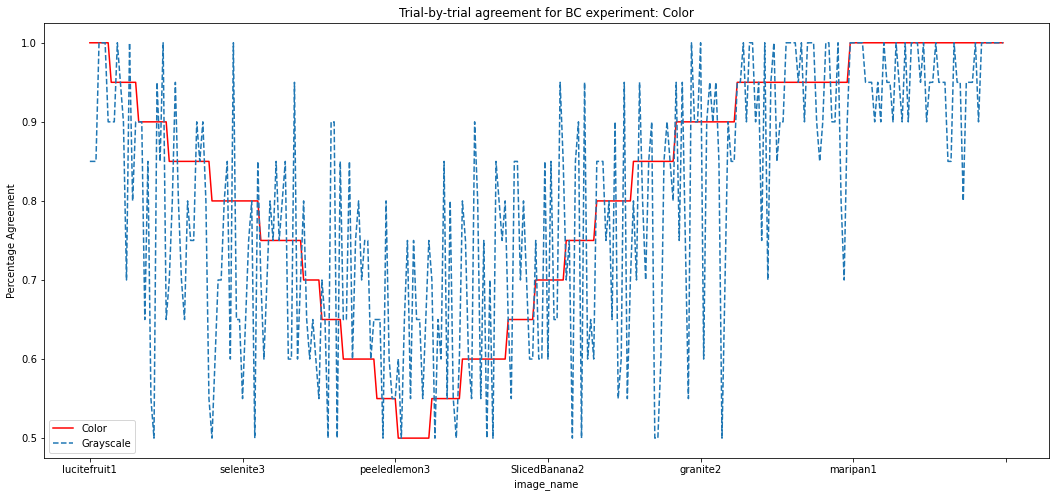

In [10]:
# @title (I) Plot BC exp. percent agreement for color and grayscale conditions
agreement_color_line = sorted_color_sar.plot.line(x='image_name', y= 'agreement', figsize=(18,8), label='Color', color = 'r')
sorted_gray_sar.plot.line(ax=agreement_color_line,x='image_name', y= 'agreement', linestyle='dashed', label='Grayscale')
plt.title("Trial-by-trial agreement for BC experiment: Color")
plt.ylabel("Percentage Agreement")

<ipython-input-5-1b4d7aa2ccbb>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_switched['condition'] = label_switched['color label'].str.cat(label_switched['gray label'], sep=' -> ')


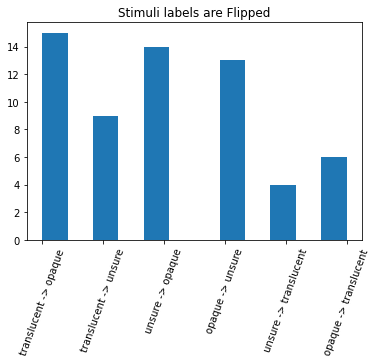

In [11]:
# @title (II) Classification label flips
diff_label_BC = get_BC_diff(1)

Show examples of 'opaque -> translucent'

In [13]:
pd.set_option('display.max_rows', None)
#diff_label_BC
diff_label_BC.loc[diff_label_BC['condition'] == "opaque -> translucent"]

,image_name,Color-Gray,color label,gray label,condition
49,persimmon1,4,opaque,translucent,opaque -> translucent
69,tulumba1,6,opaque,translucent,opaque -> translucent
239,stickytoy1,7,opaque,translucent,opaque -> translucent
2,grapefruit5,8,opaque,translucent,opaque -> translucent
10,shrimp1,8,opaque,translucent,opaque -> translucent
29,wax13,8,opaque,translucent,opaque -> translucent


Show examples of 'translucent -> opaque'

In [14]:
diff_label_BC.loc[diff_label_BC['condition'] == "translucent -> opaque"]

,image_name,Color-Gray,color label,gray label,condition
131,waxcube3,-11,translucent,opaque,translucent -> opaque
34,glycerin4,-11,translucent,opaque,translucent -> opaque
24,greensoap1,-11,translucent,opaque,translucent -> opaque
65,DriedCantaloupe4,-9,translucent,opaque,translucent -> opaque
126,ambersoap,-8,translucent,opaque,translucent -> opaque
248,plastic1BB,-7,translucent,opaque,translucent -> opaque
102,jade11,-7,translucent,opaque,translucent -> opaque
276,raspberry2,-7,translucent,opaque,translucent -> opaque
114,toy2BB,-7,translucent,opaque,translucent -> opaque
275,frostedglass1,-7,translucent,opaque,translucent -> opaque


# Figure 4

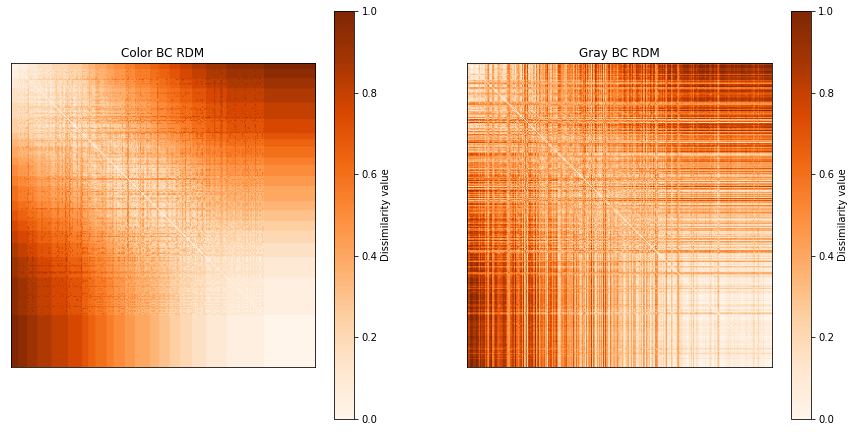

Wilcox P of Translucent region: 0.0 U: 4787382.0
Wilcox P of Unsure region: 4.76178956978729e-35 U: 34777.0
Wilcox P of Opaque region: 1.9891404902160212e-153 U: 102906997.5


In [17]:
# @title (I) BC RDMs
plot_BC_rdm(color_BC, gray_BC)

<ipython-input-5-1b4d7aa2ccbb>:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(p_matrix_inv, dtype=np.bool)
<ipython-input-5-1b4d7aa2ccbb>:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(p_matrix_inv, dtype=np.bool)


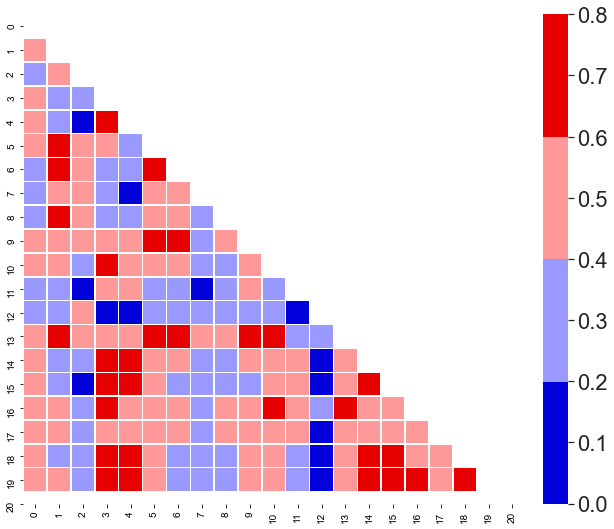

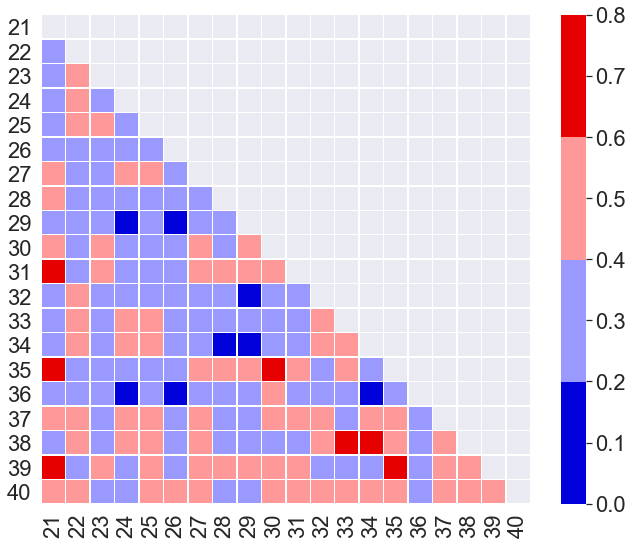

In [18]:
# @title (II) Cohen's Kappa Heatmap
## Color condition
plot_kappa_matrix(color_BC, "color", "seismic")

## Grayscale condition
plot_kappa_matrix(gray_BC, "gray", "seismic")

# Figure 5

In [ ]:
# @title Get SAR data from observers used for histogram
see_through_color, gloss_color, softness_color, glow_color, density_color = get_each_attribute(SAR_color_path, order = "trial_num")
see_through_gray, gloss_gray, softness_gray, glow_gray, density_gray = get_each_attribute(SAR_gray_path, order = "trial_num")

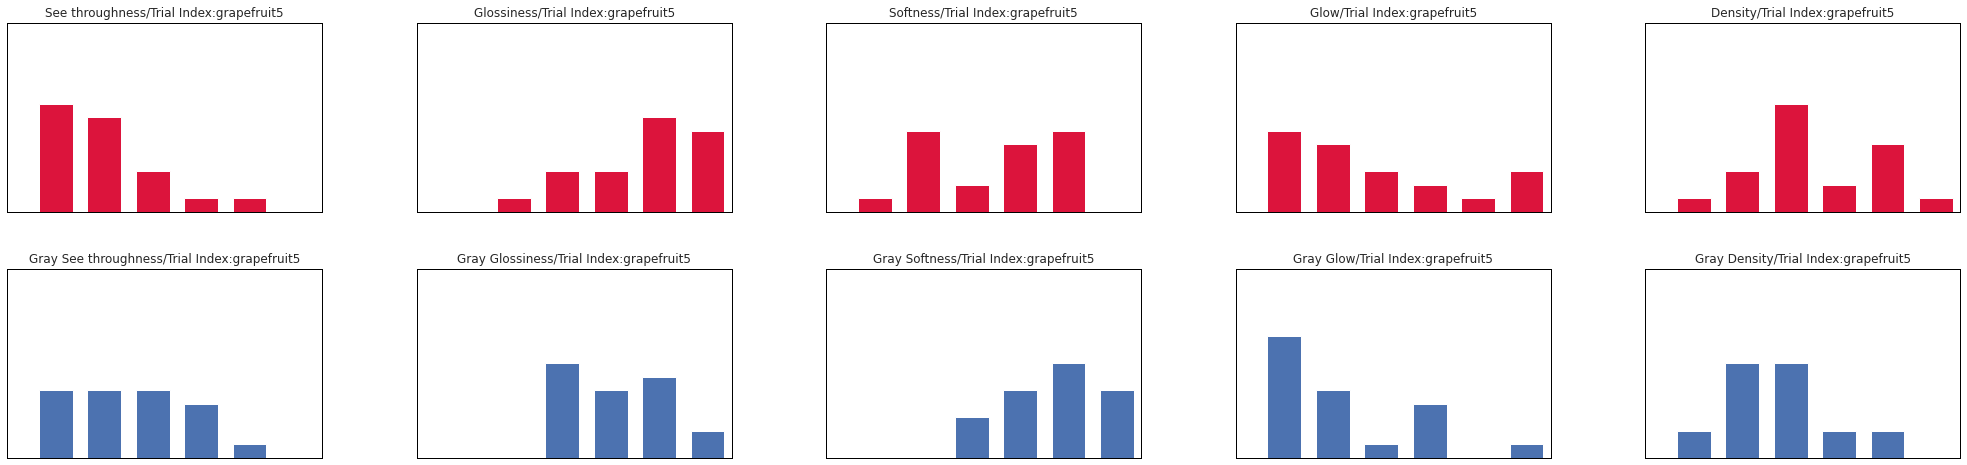

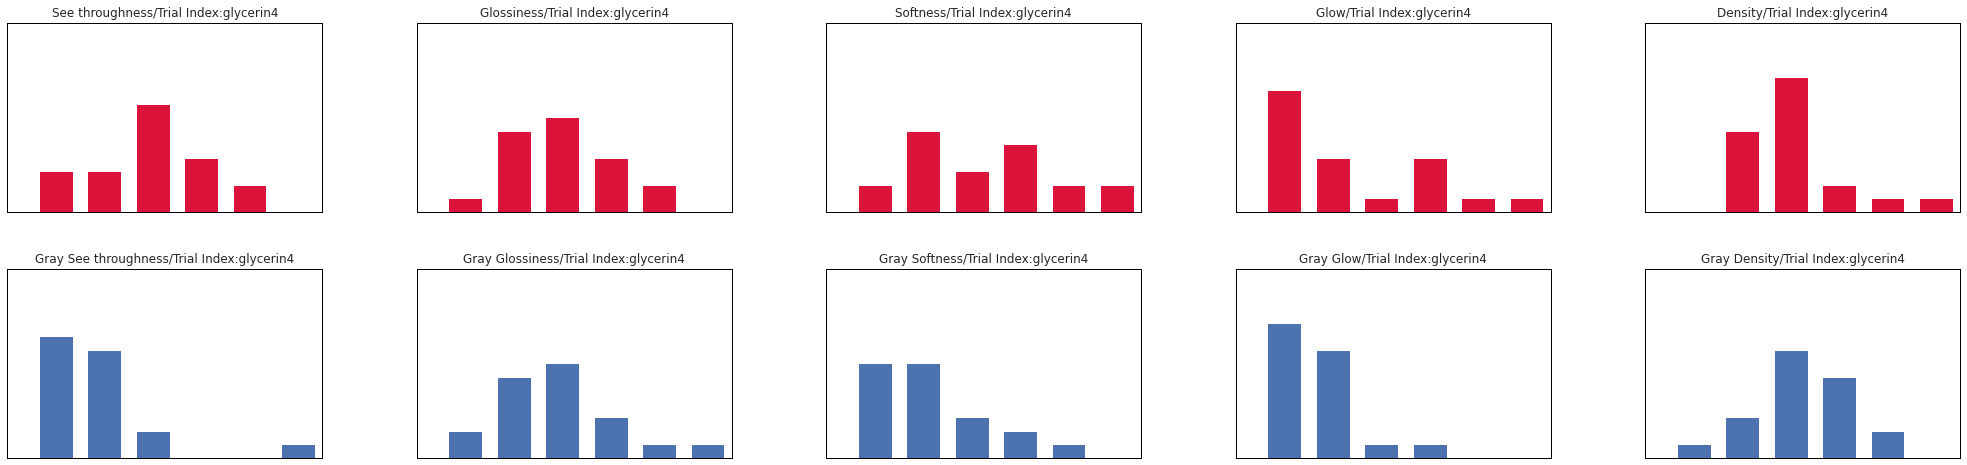

In [ ]:
# @title (I) Plot histograms for example images
plot_attr_histogram('grapefruit5')
plot_attr_histogram('glycerin4')

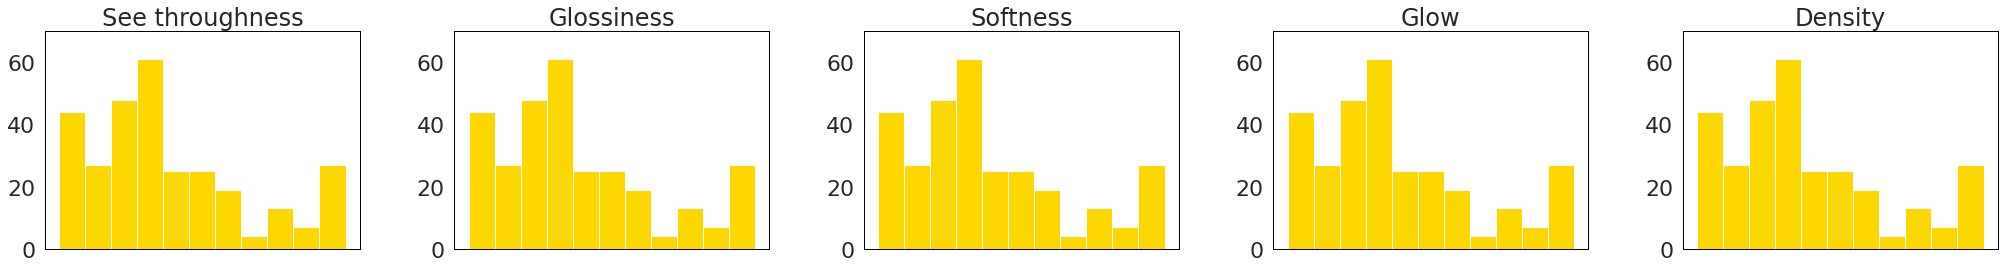

In [ ]:
# @title (II) Plot distribution of KL divergence of 300 images
KL_value_image = compute_KL_images(mode='gray|color', color_type = None)
plt_kl_hist(KL_value_image)

In [ ]:
# @title (III) Plot skewness
skew_adj_color = get_skew(SAR_color_path, color_stimiluli_path_sar, BC_color_path, color_stimiluli_path_bc)
skew_adj_gray = get_skew(SAR_gray_path, color_stimiluli_path_sar, BC_gray_path, color_stimiluli_path_bc)

*   Above centerline: Grayscale condition has higher ratings
*   Below centerline: Color condition has higher ratings

Shift see through skew_see_through


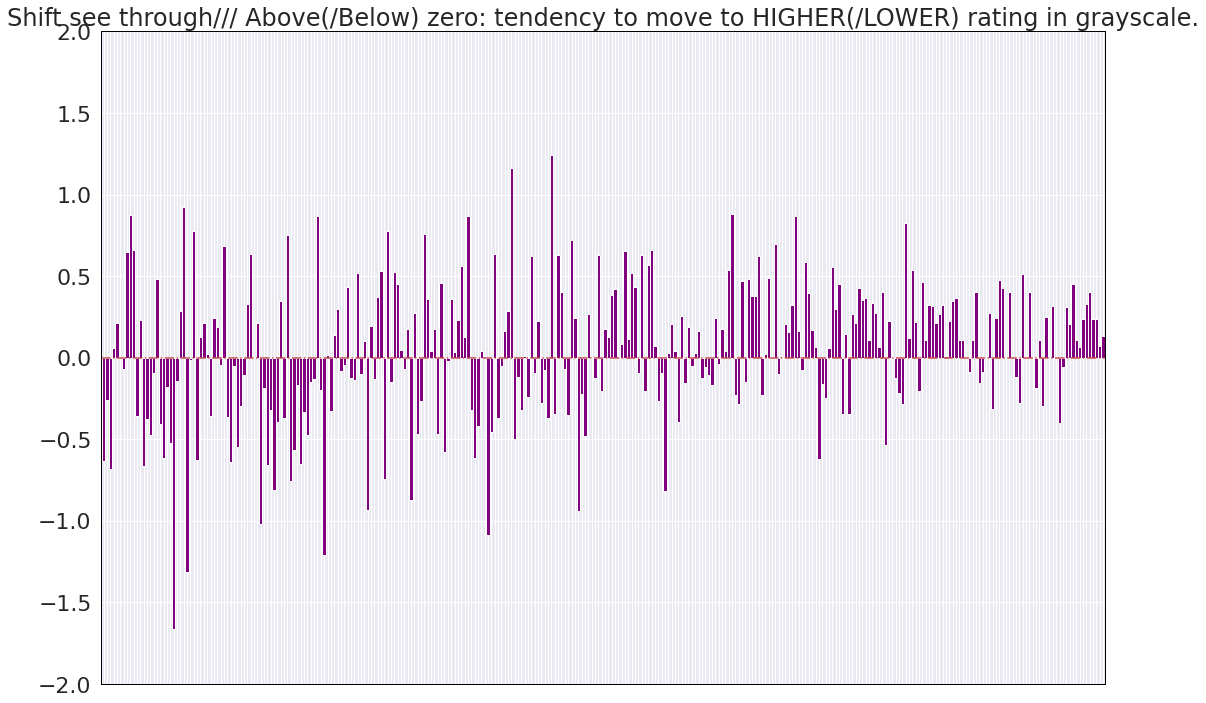

Shift gloss skew_gloss


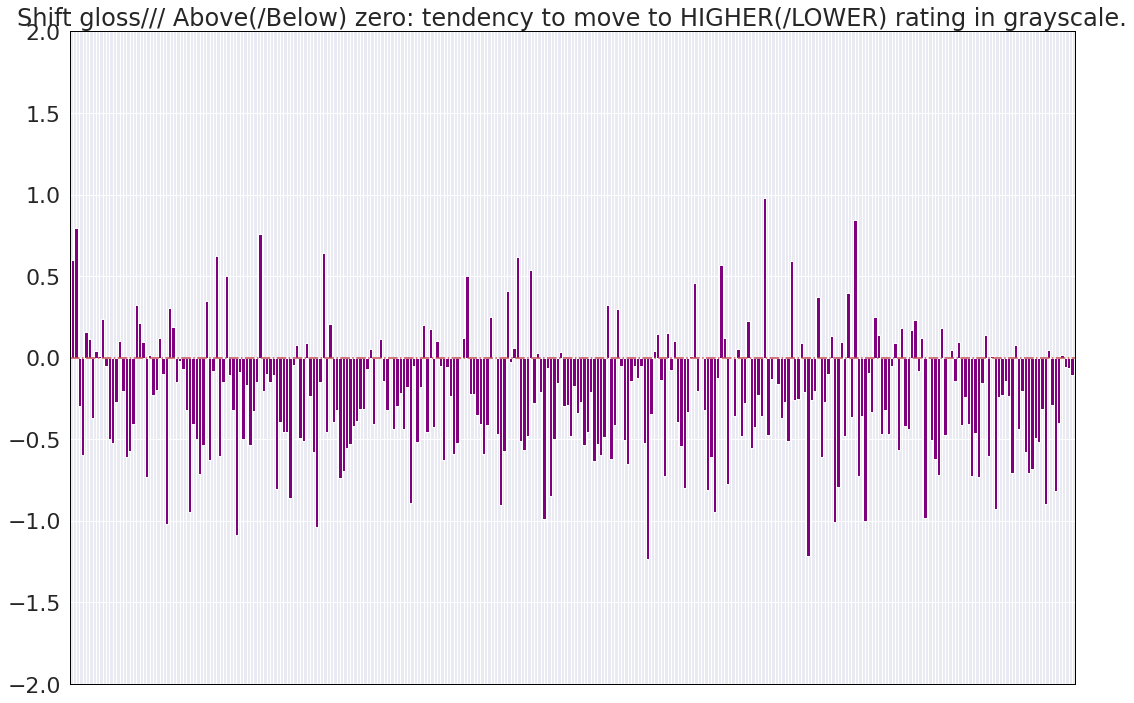

Shift softness skew_softness


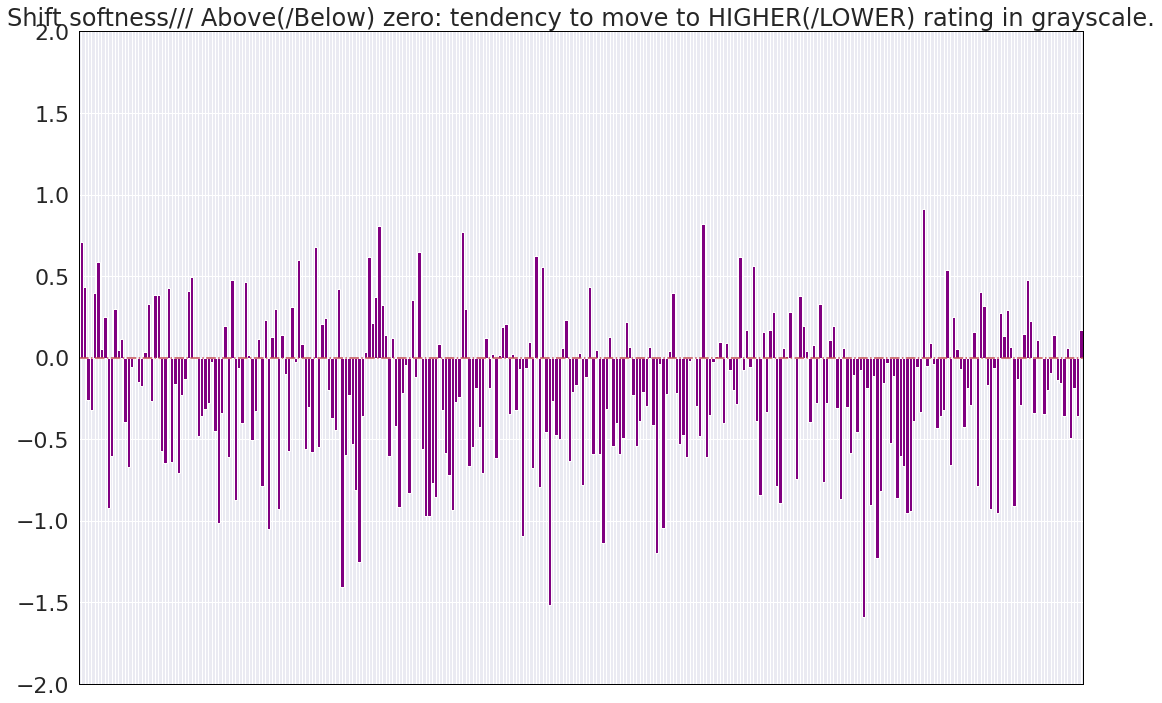

Shift glow skew_glow


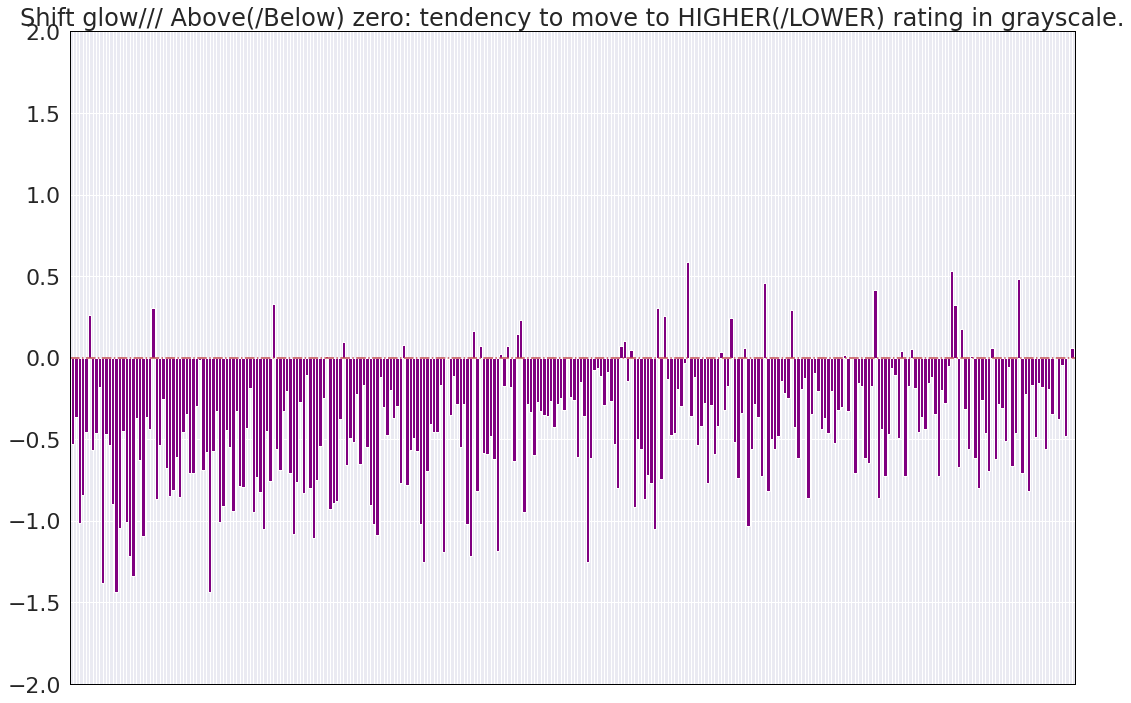

Shift density skew_density


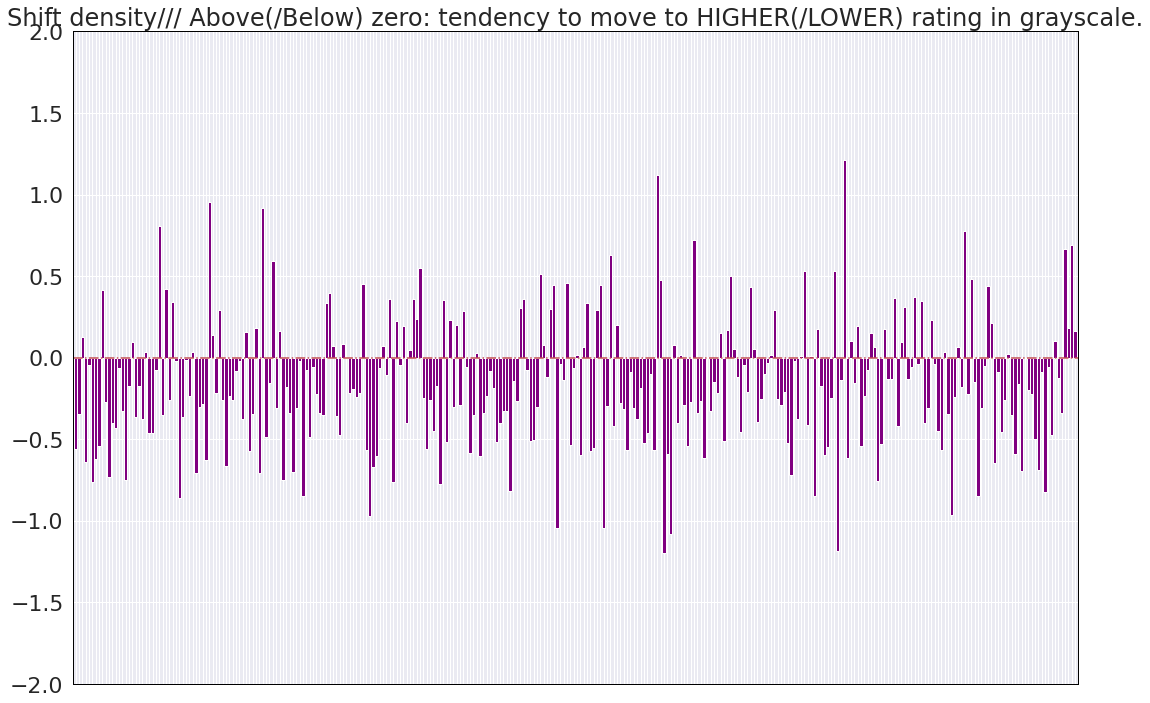

In [ ]:
plot_skew_shift(skew_adj_color,skew_adj_gray)

# Figure 10

In [19]:
color_people_data  = get_SAR_BC_people(SAR_color_path, color_stimiluli_path_sar, BC_color_path, color_stimiluli_path_bc)
gray_people_data  = get_SAR_BC_people(SAR_gray_path, color_stimiluli_path_sar, BC_gray_path, color_stimiluli_path_bc)

['Olivia Freides', 'Jarol Allen', 'Whitney', 'Jesse', 'Shaiyan', 'Justice Suh', 'Meredith Shimer', 'Zumrud Hajiyeva', 'Amber Zhang', 'Minh-Tuan Nguyen', 'Maulie Clermont', 'Christina Wu', 'Tami Yousafi', 'Shrija Moharar', 'Yiding Wang', 'Lillian Bertrand', 'Yuxin Guan', 'Zach Switzer', 'Sheng Kai Liao', 'Yunqian Lin']
['Jeffrey Zhang', 'Jessica U', 'Daniel Kim', 'Jiachen Yao', 'Kaitlyn Kelley', 'Lauren Cassidy', 'Owen Boice', 'Juliana Dutt', 'Raven Calloway', 'Emily Porciello', 'Lara Jaber', 'Mack Guthrie', 'Inanna Crabbe', 'Wei-Hua Hsu', 'Sergey Orlov', 'Rempee Kalia', 'Jonathan Mao', 'Emily Barnes', 'Lillian Hornung', 'John Starkel']


Save observers data as csv files for Logistic Regression analysis in R.

In [21]:
# Save data to a csv file. This data is provided in the 'exp data' folder 
#for i in range(20):
#    color_people_data[i].to_csv('/Users/chenxiliao/Dropbox/JOV 2021/exp data/color_BC_SAR/Color Person' + str(i+1) +'.csv')
#    gray_people_data[i].to_csv('/Users/chenxiliao/Dropbox/JOV 2021/exp data/gray_BC_SAR/Gray Person' + str(i+1) +'.csv')


# Figure 12

Color Condition barchart

Number of observers: 15
Number of observers: 15


<AxesSubplot:xlabel='image_name'>

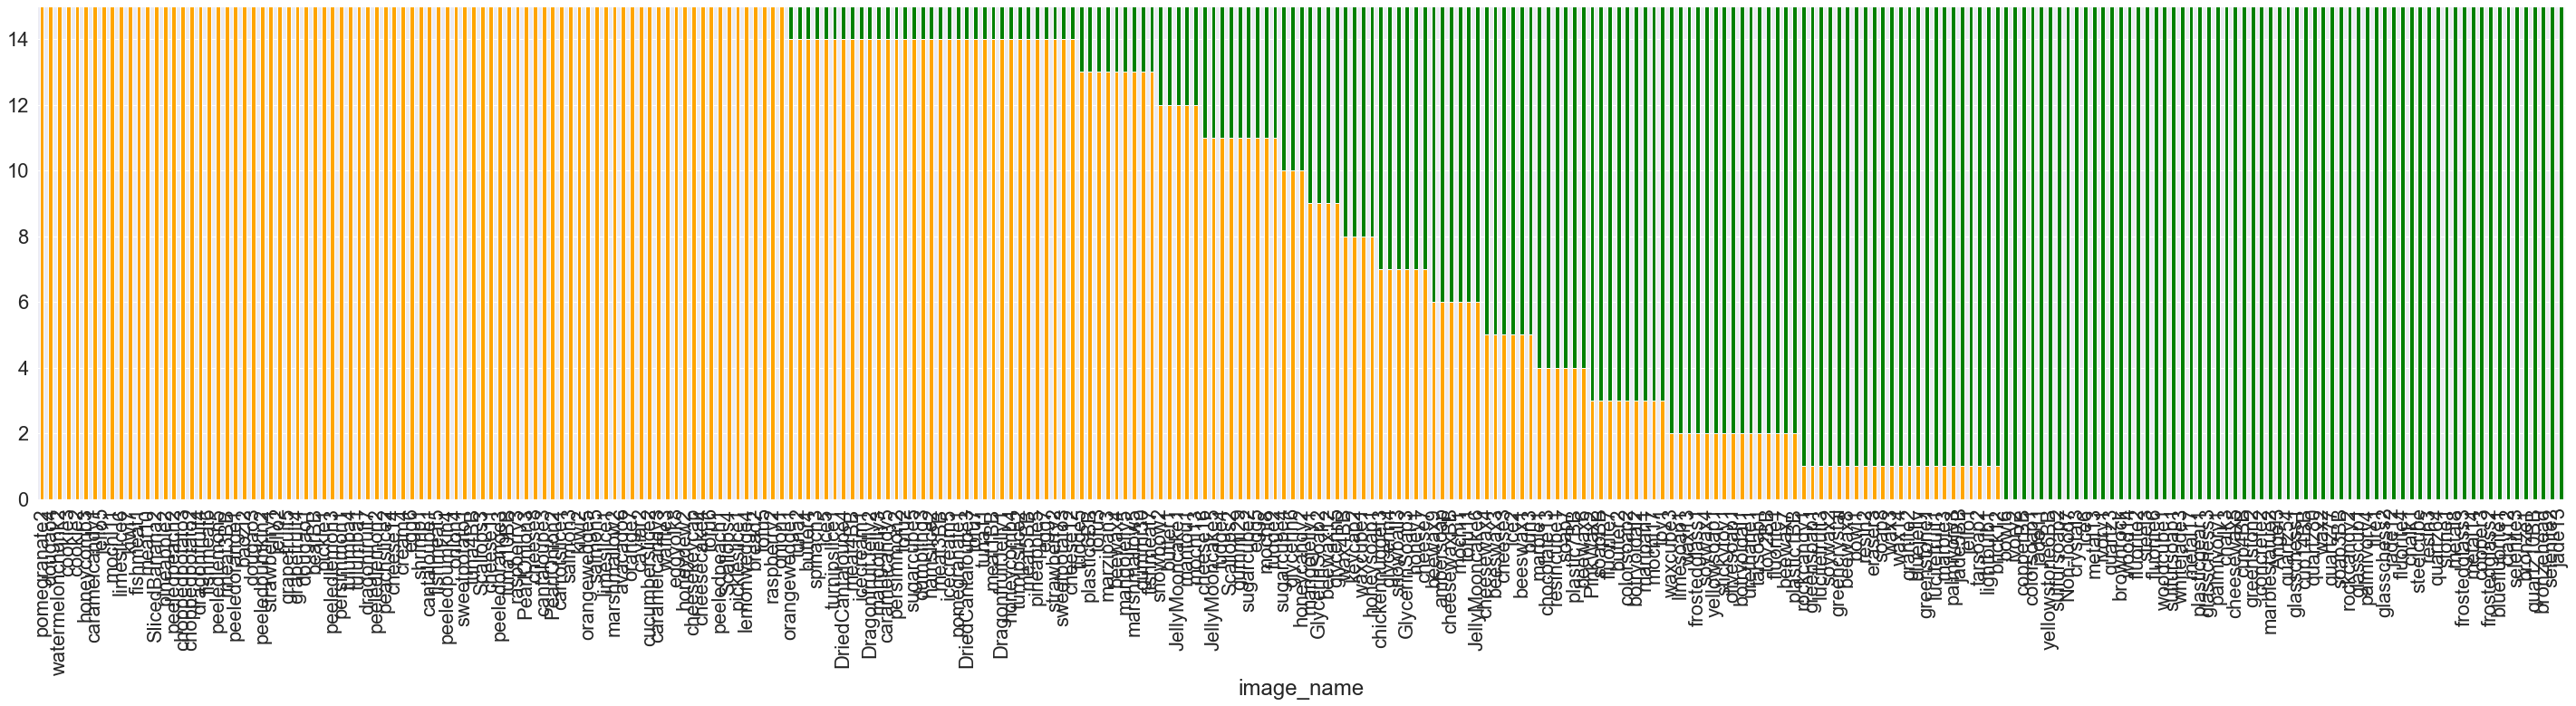

In [22]:
binary_naming_color, mat_result_color = get_naming(naming_color_path, mode='food')
ten_naming_color, ten_mat_color = get_naming(naming_color_path, mode='ten')
mat_result_color.plot(kind='bar', stacked=True, color=["orange","green"],  figsize=(50,10) , ylim=(0,15), legend=False)

Grayscale Condition barchart

Number of observers: 15
Number of observers: 15


<AxesSubplot:xlabel='image_name'>

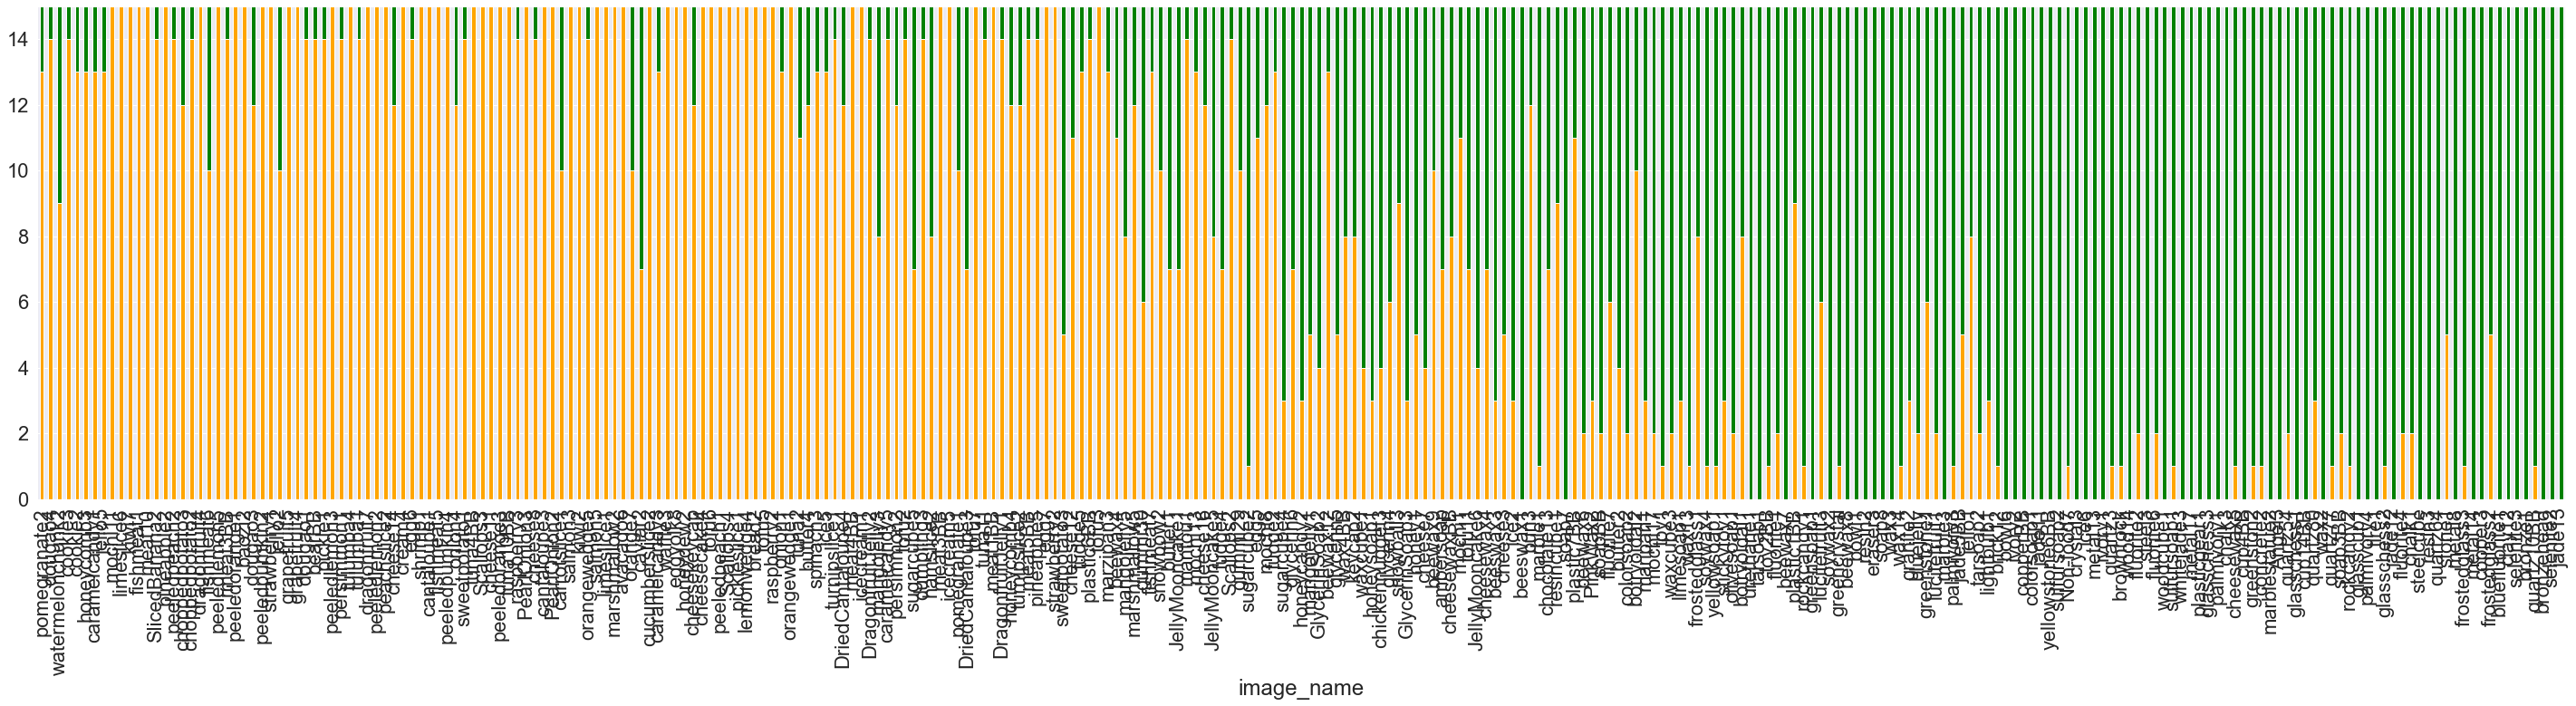

In [23]:
binary_naming_gray, mat_result_gray = get_naming(naming_gray_path, 'food')
ten_naming_gray, ten_mat_gray = get_naming(naming_gray_path, 'ten')
mat_result_gray = mat_result_gray.reindex(mat_result_color.index)

mat_result_gray.plot(kind='bar', stacked=True, color=["orange","green"], figsize=(50,10) , ylim=(0,15), legend=False)

# Figure 13

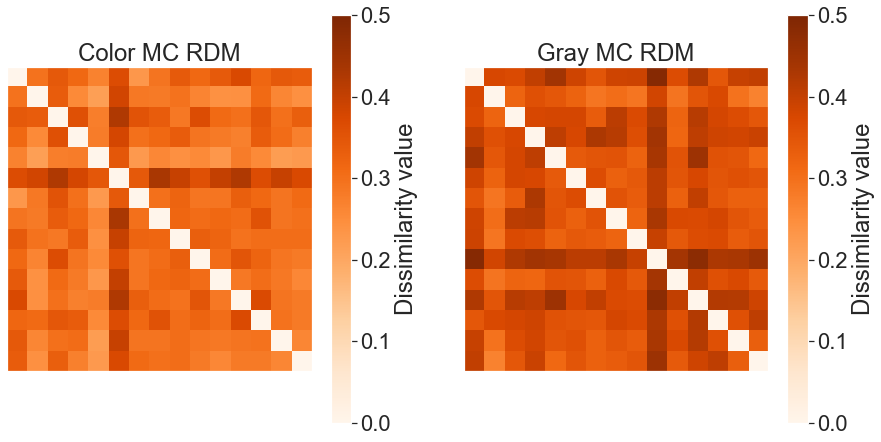

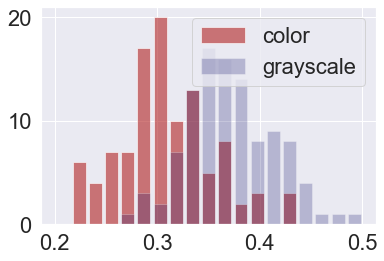

Mann Whitney U P value: 3.4327110191251564e-18 U: 1719.0


In [24]:
# @title (II) Distribution of dissimilarity values
plot_naming_people_rdm(ten_naming_color, ten_naming_gray, lim = 0.5)

# Figure 14

In [25]:
color_people_10cat = get_SAR_BC_naming('ten', SAR_color_path, color_stimiluli_path_sar, BC_color_path, color_stimiluli_path_bc, naming_color_path, material_naming_path )
gray_people_10cat = get_SAR_BC_naming('ten', SAR_gray_path, color_stimiluli_path_sar, BC_gray_path, color_stimiluli_path_bc, naming_gray_path, material_naming_path)

['Olivia Freides', 'Jarol Allen', 'Whitney', 'Jesse', 'Shaiyan', 'Justice Suh', 'Meredith Shimer', 'Zumrud Hajiyeva', 'Amber Zhang', 'Minh-Tuan Nguyen', 'Maulie Clermont', 'Christina Wu', 'Tami Yousafi', 'Shrija Moharar', 'Yiding Wang', 'Lillian Bertrand', 'Yuxin Guan', 'Zach Switzer', 'Sheng Kai Liao', 'Yunqian Lin']
['Jeffrey Zhang', 'Jessica U', 'Daniel Kim', 'Jiachen Yao', 'Kaitlyn Kelley', 'Lauren Cassidy', 'Owen Boice', 'Juliana Dutt', 'Raven Calloway', 'Emily Porciello', 'Lara Jaber', 'Mack Guthrie', 'Inanna Crabbe', 'Wei-Hua Hsu', 'Sergey Orlov', 'Rempee Kalia', 'Jonathan Mao', 'Emily Barnes', 'Lillian Hornung', 'John Starkel']


t-SNE plot for Color condition

[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 286 samples in 0.007s...
[t-SNE] Computed neighbors for 286 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 286 / 286
[t-SNE] Mean sigma: 0.771352
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.914902
[t-SNE] KL divergence after 350 iterations: 0.613515
TSNE plot for color observer with 10 categories 0
[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 286 samples in 0.000s...
[t-SNE] Computed neighbors for 286 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 286 / 286
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.199417
[t-SNE] KL divergence after 350 iterations: 0.432157
TSNE plot for color observer with 10 categories 1
[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 286 samples in 0.000s...
[t-SNE] Computed neighbors for 286 samples in 0.002s...
[t-SNE] Computed conditional probab

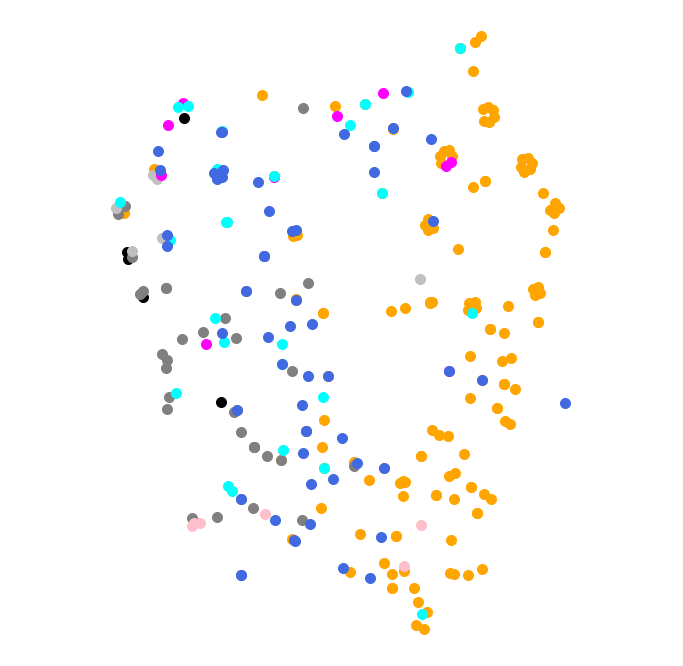

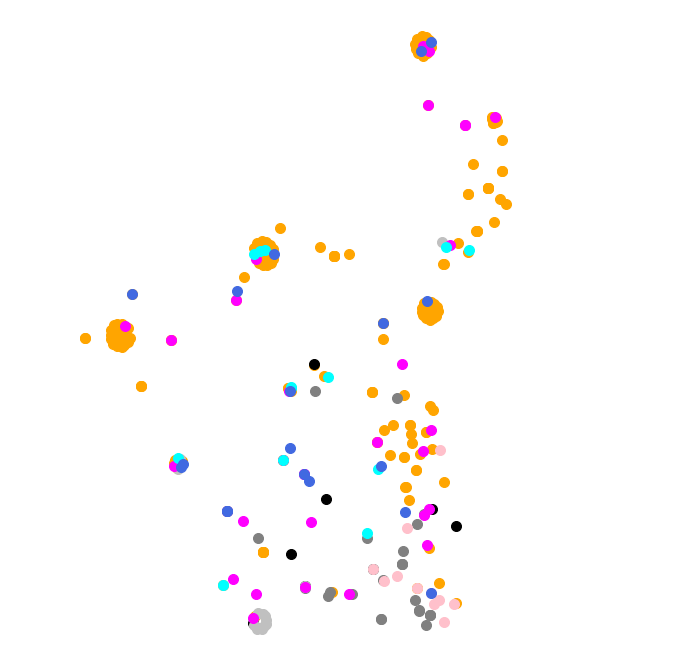

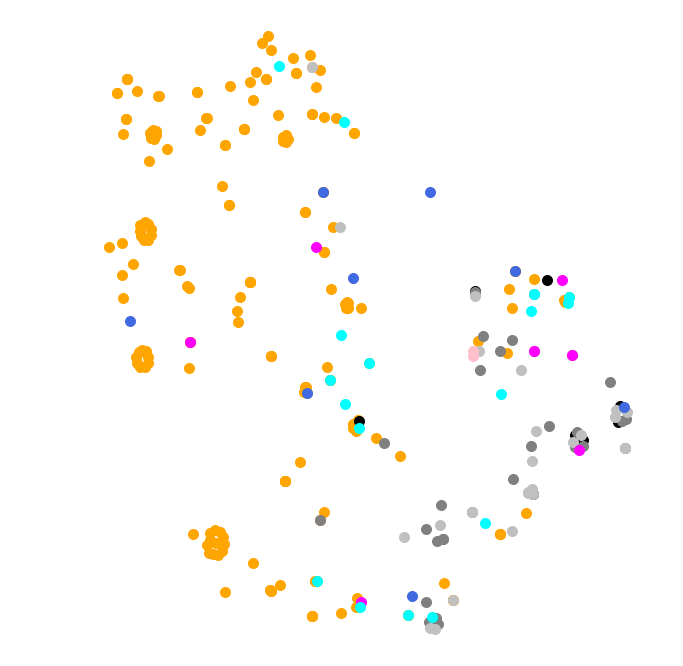

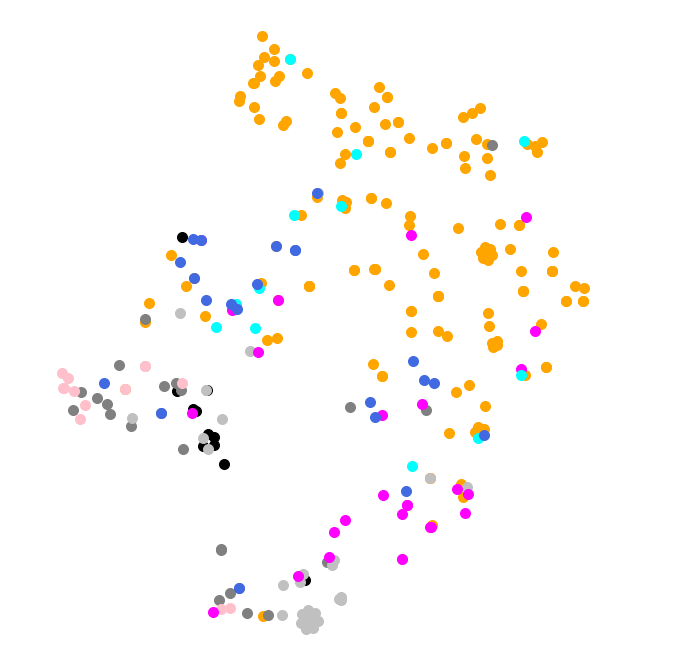

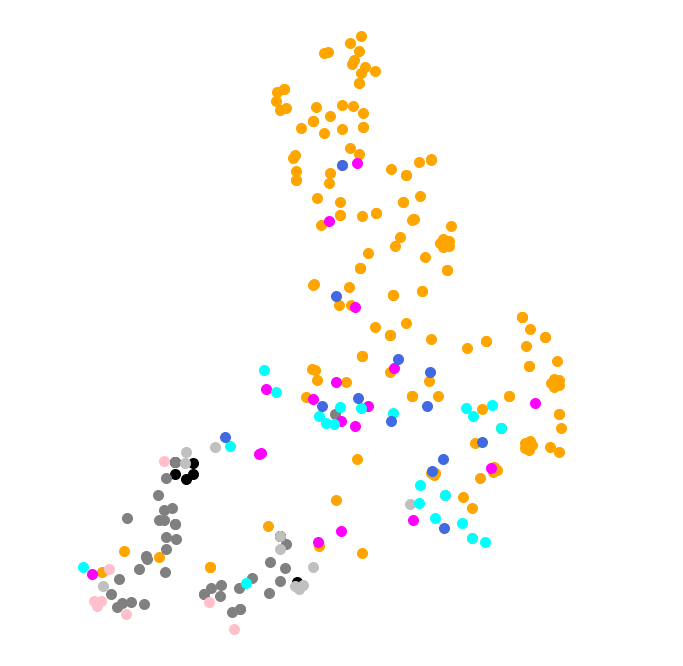

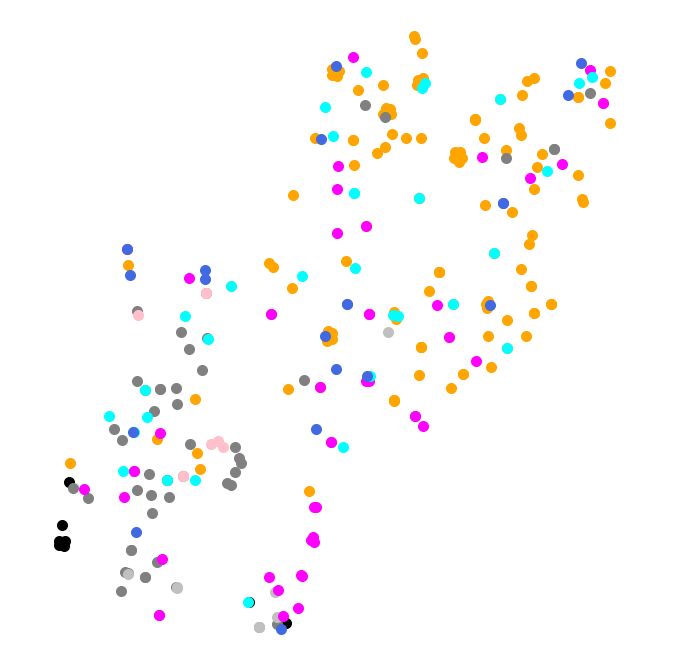

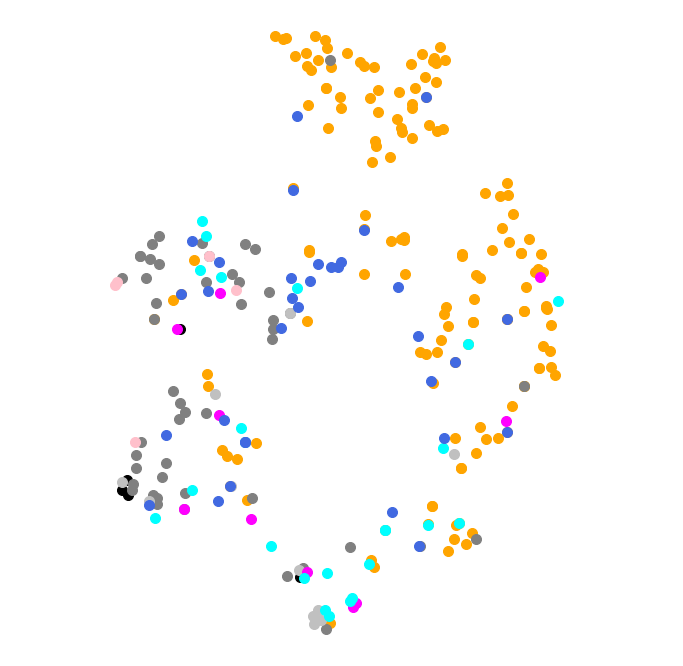

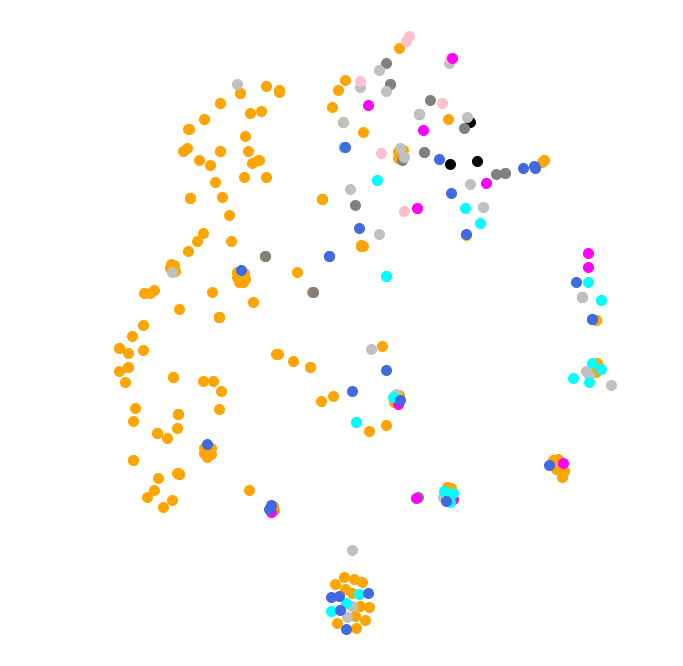

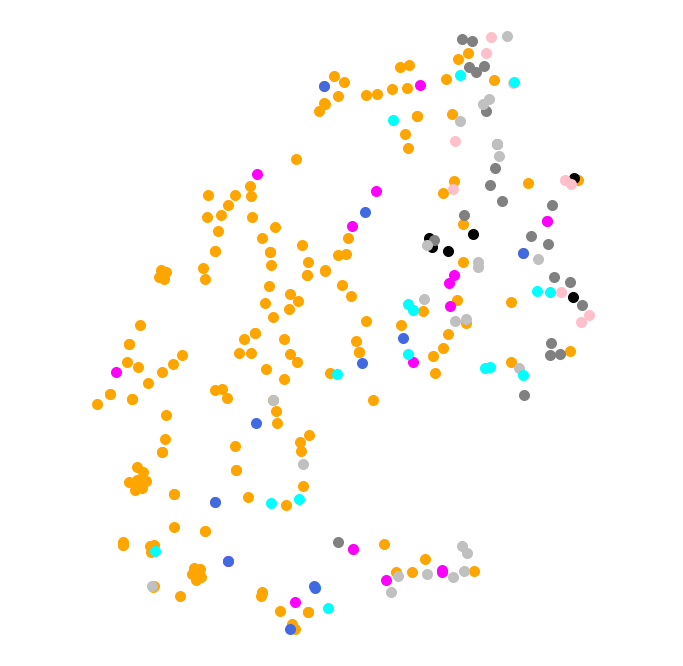

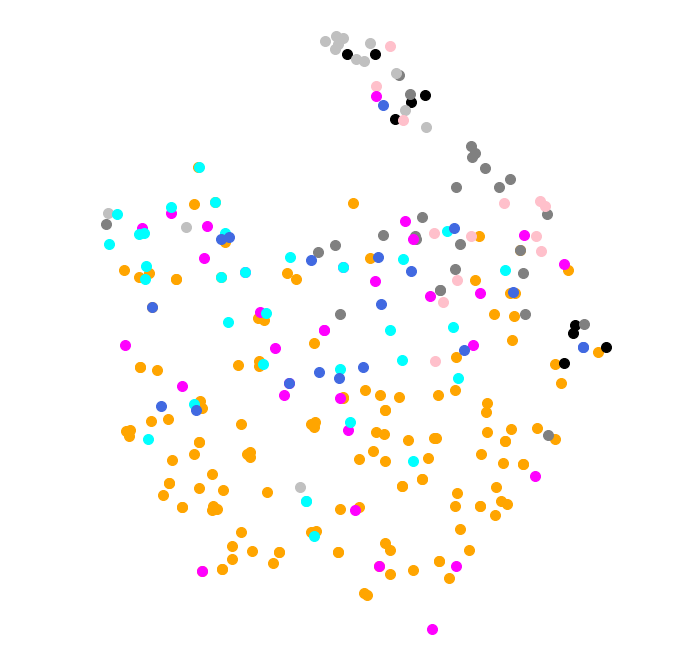

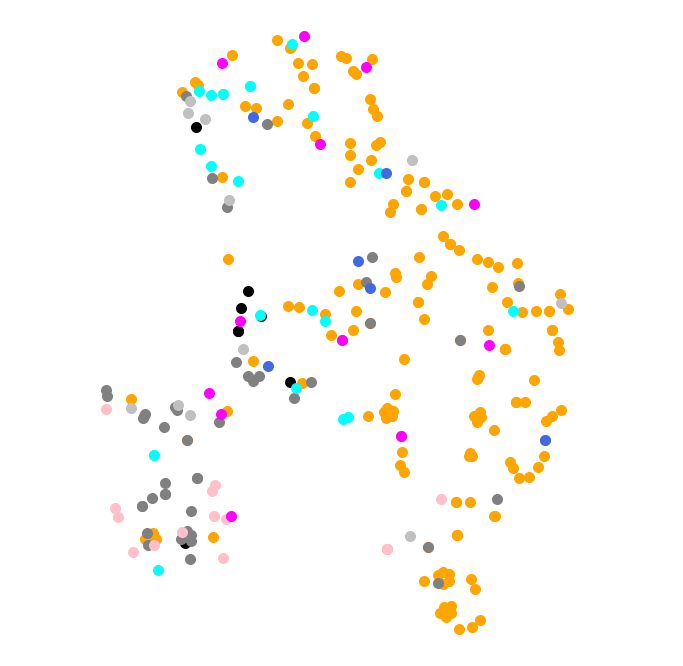

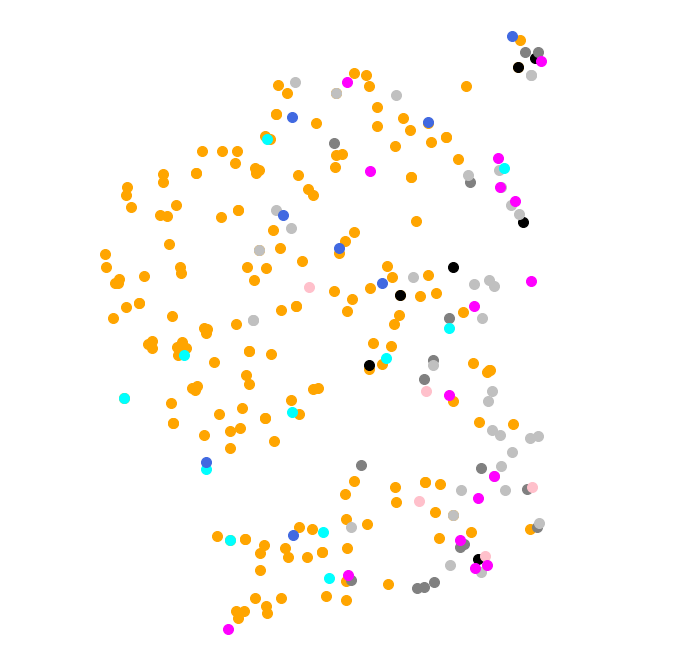

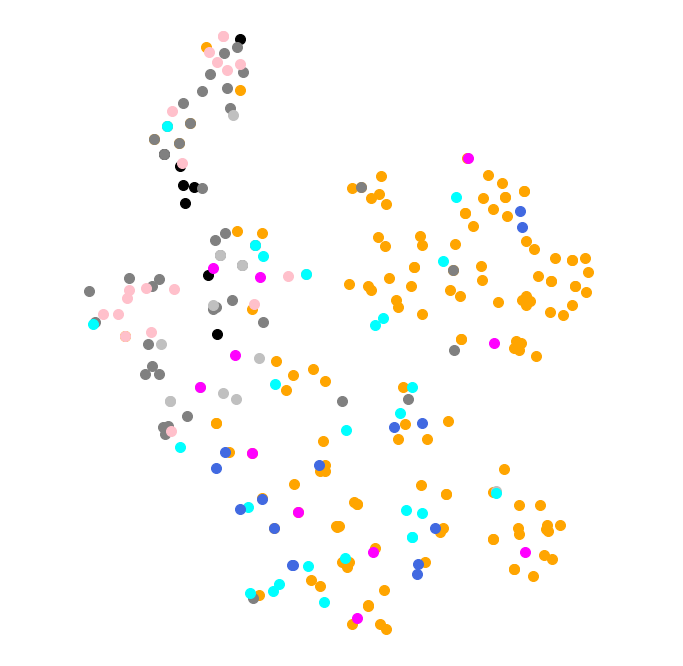

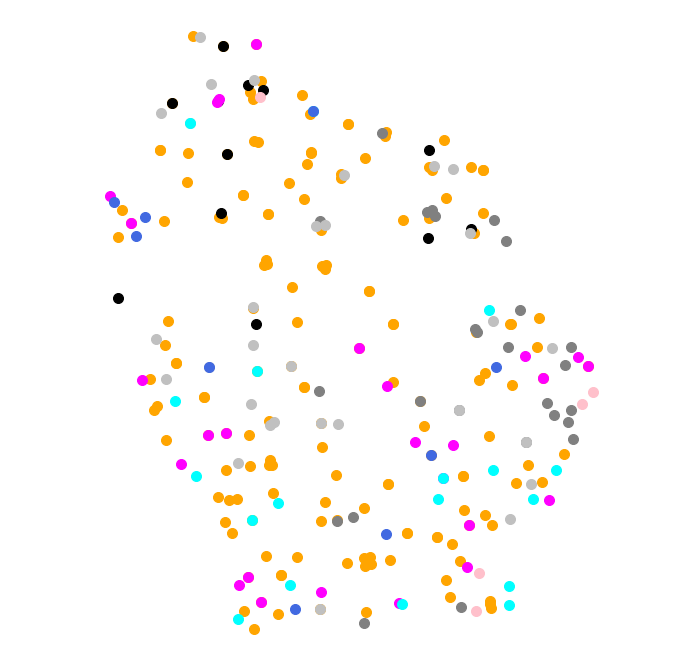

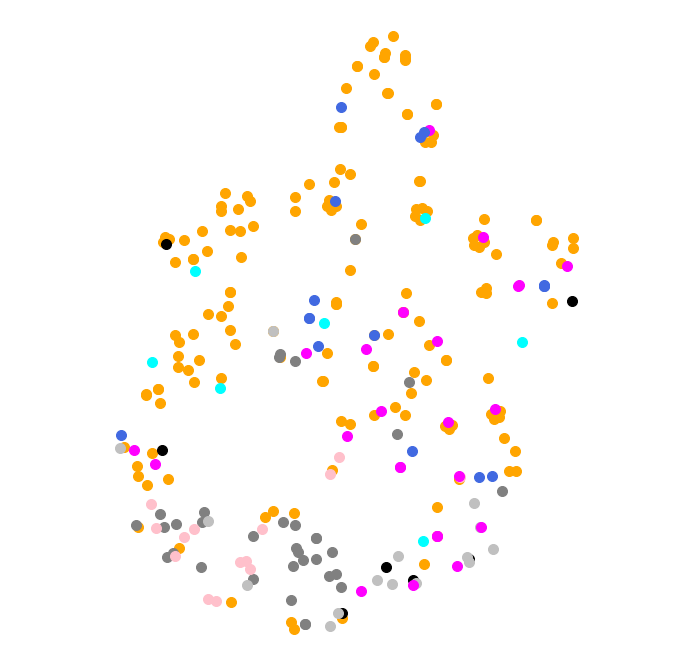

In [26]:
for i in range(len(color_people_10cat)):
  plot_TSNE(color_people_10cat[i], features_sar,'responses', targets_material_8, colors_material_8, perplexity_level = 14)
  print("TSNE plot for color observer with 10 categories", i)

t-SNE plot for Grayscale condition

[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 286 samples in 0.001s...
[t-SNE] Computed neighbors for 286 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 286 / 286
[t-SNE] Mean sigma: 0.821241
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.263504
[t-SNE] KL divergence after 350 iterations: 0.467159
TSNE plot for color observer with 10 categories 0
[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 286 samples in 0.000s...
[t-SNE] Computed neighbors for 286 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 286 / 286
[t-SNE] Mean sigma: 0.614174
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.842697
[t-SNE] KL divergence after 350 iterations: 0.629553
TSNE plot for color observer with 10 categories 1
[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 286 samples in 0.000s...
[t-SNE] Computed neighbors for 286 samples in 0.002s...
[t-SNE] Computed conditional probab

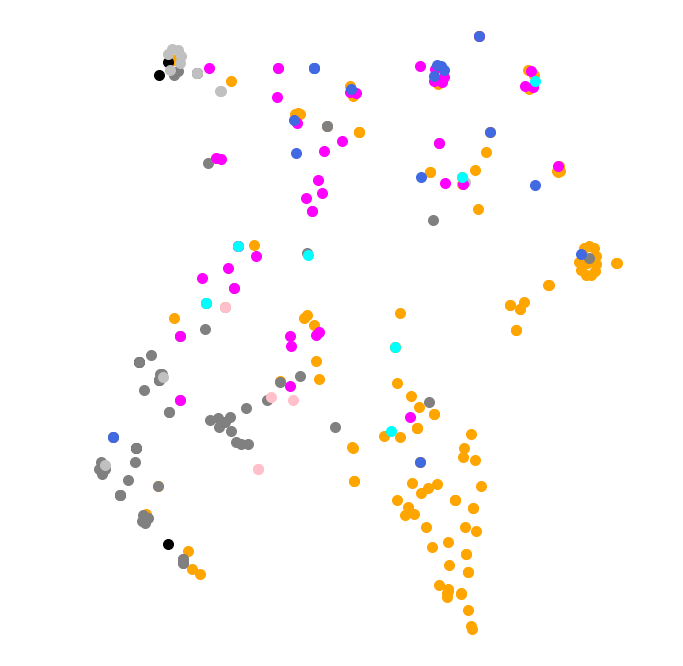

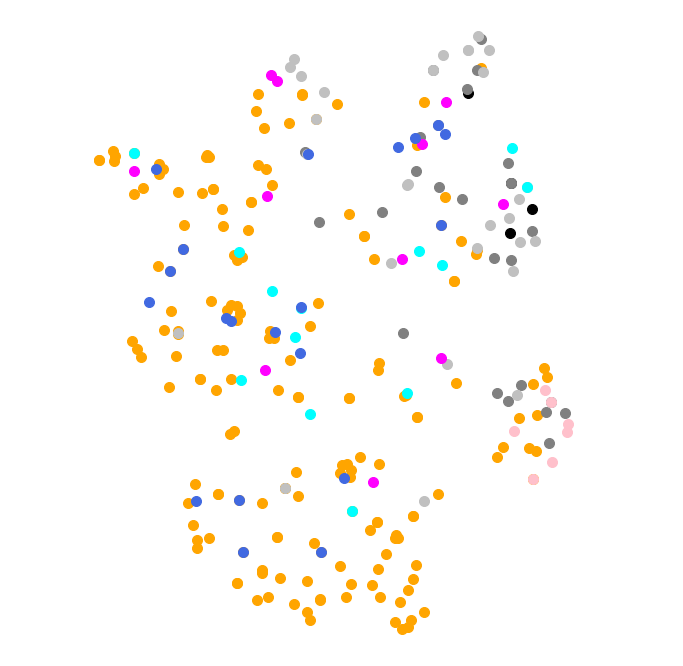

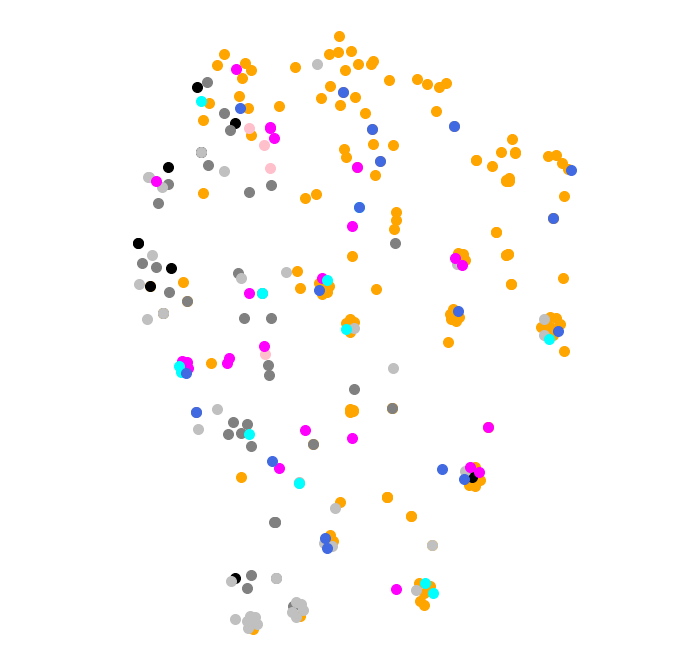

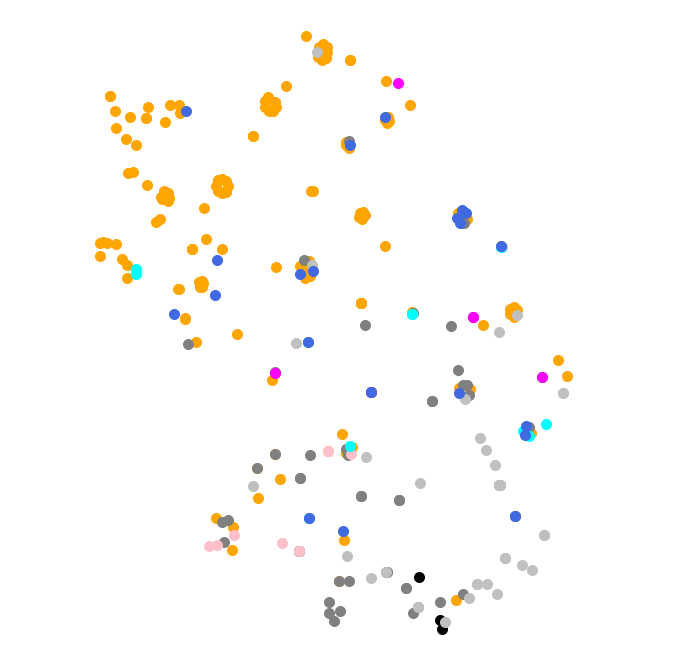

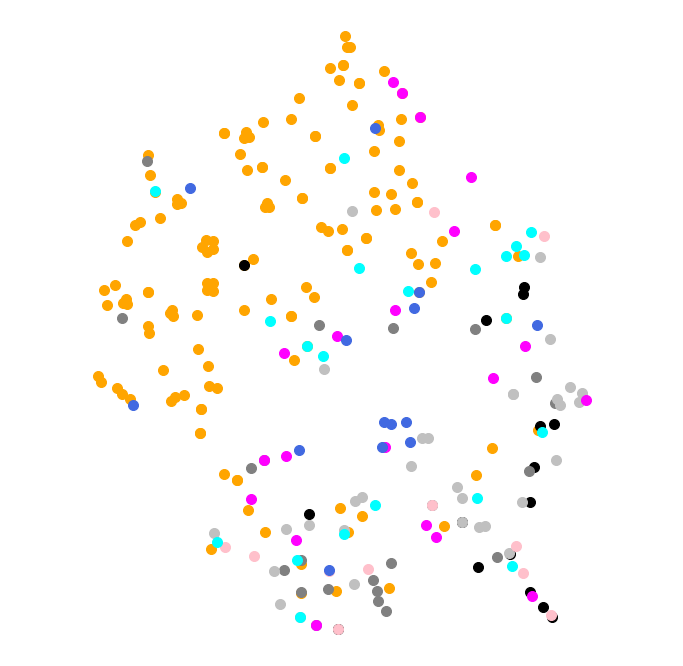

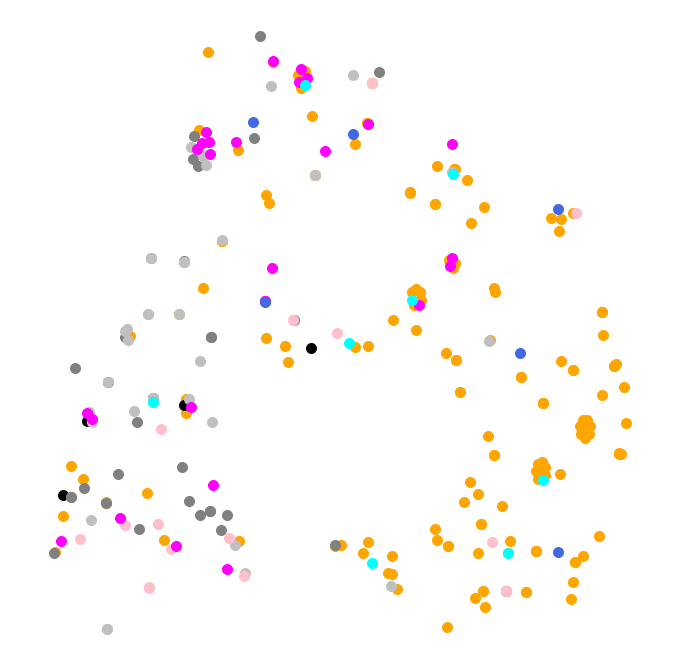

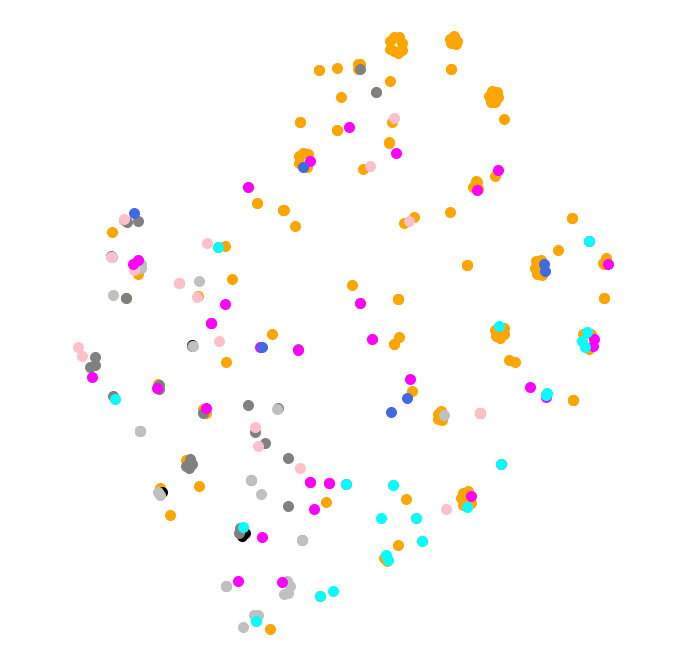

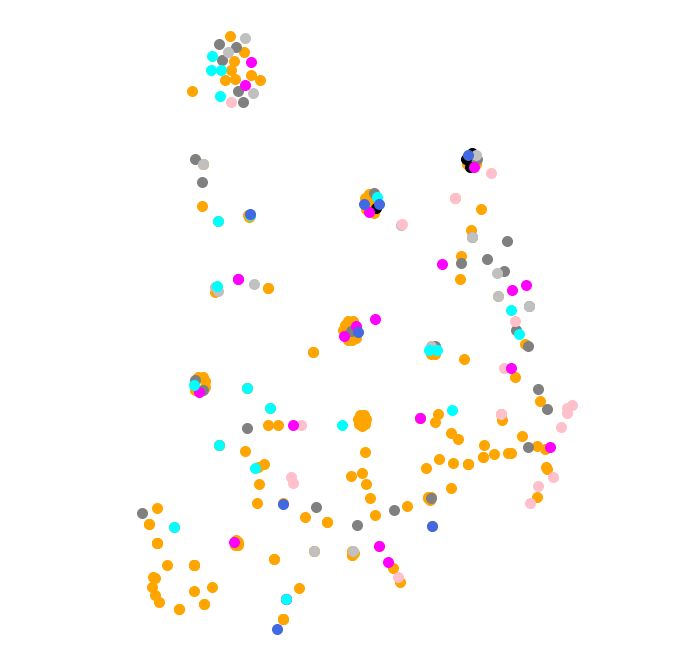

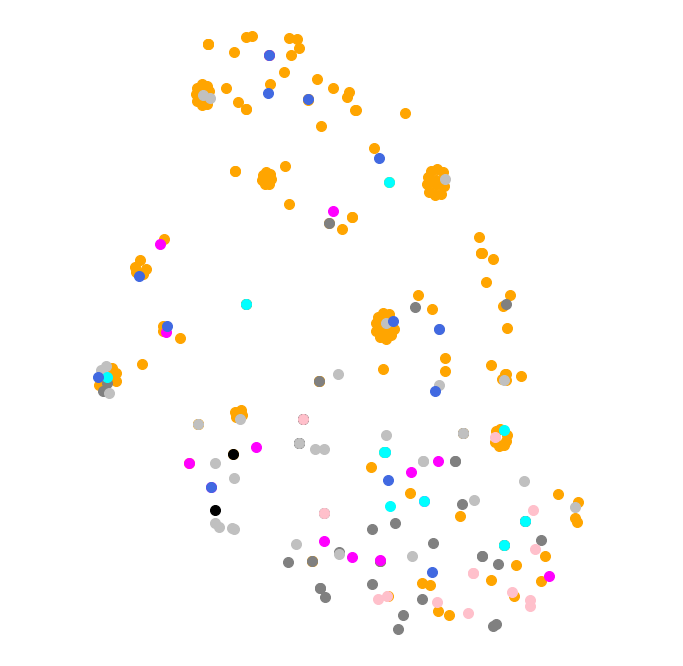

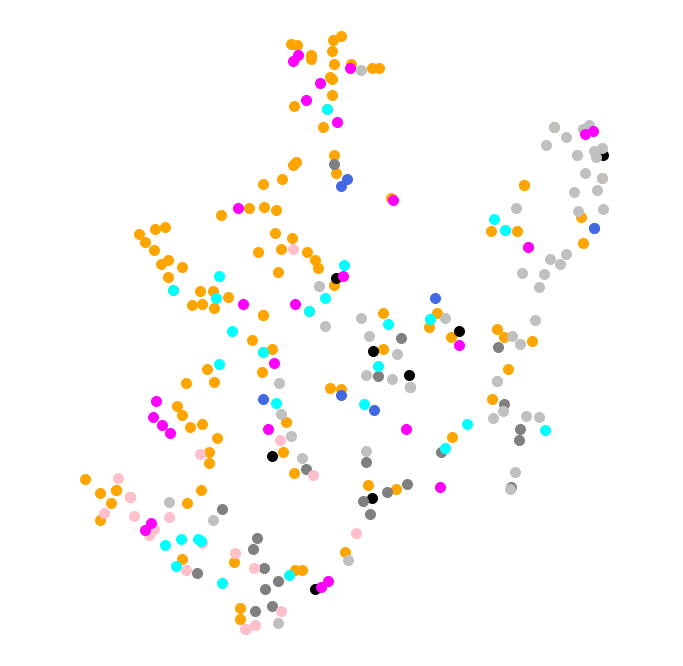

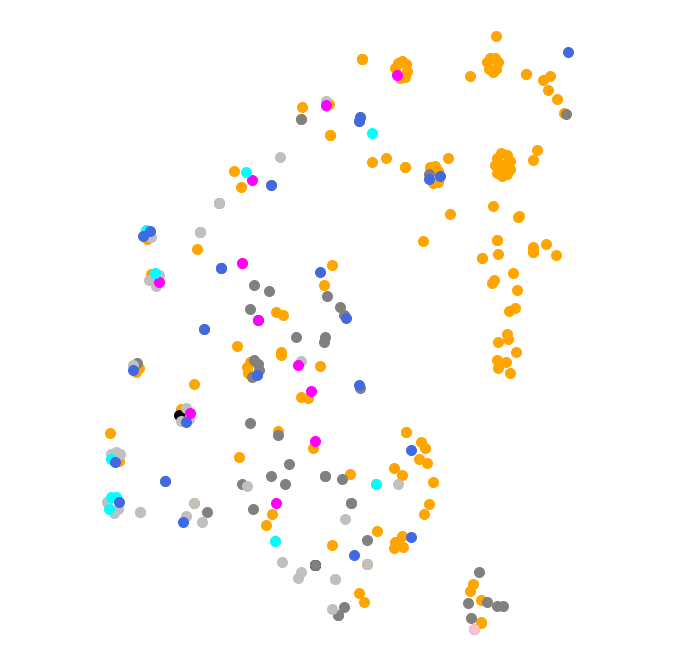

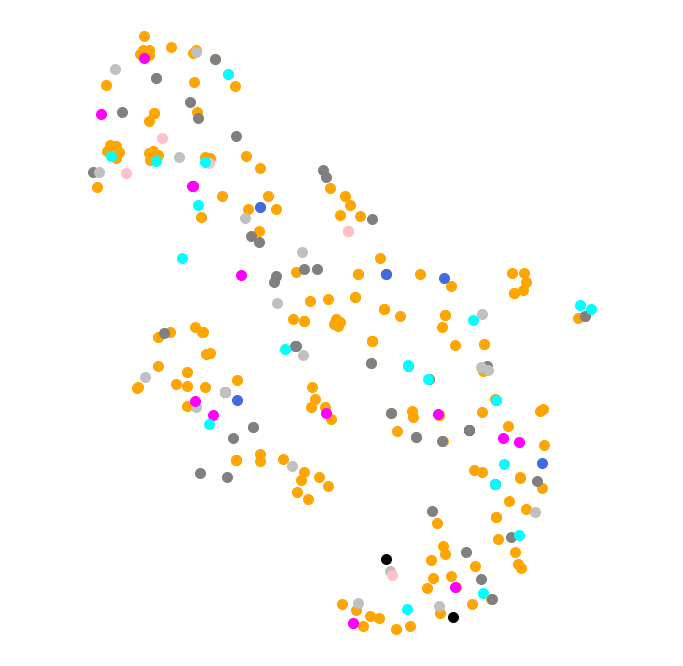

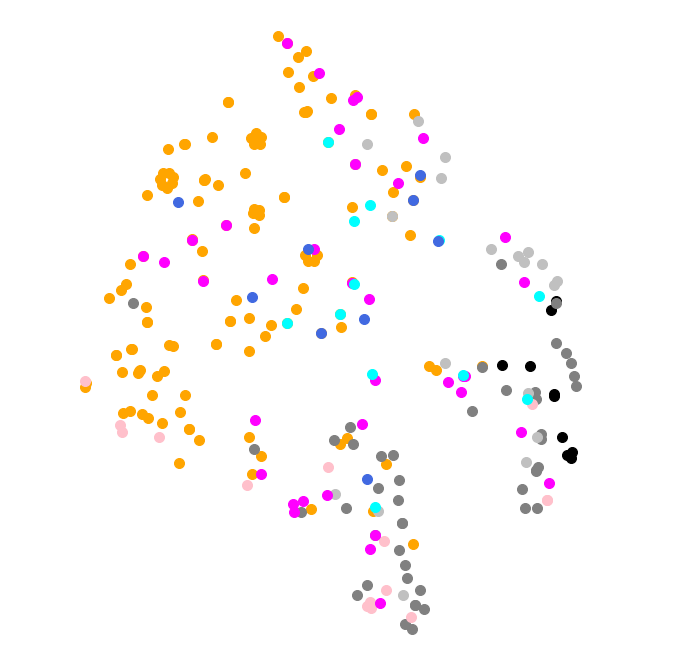

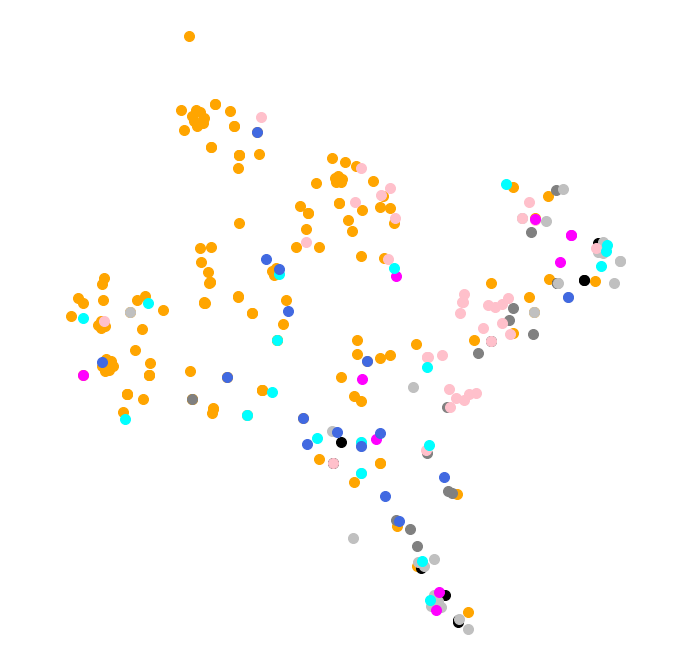

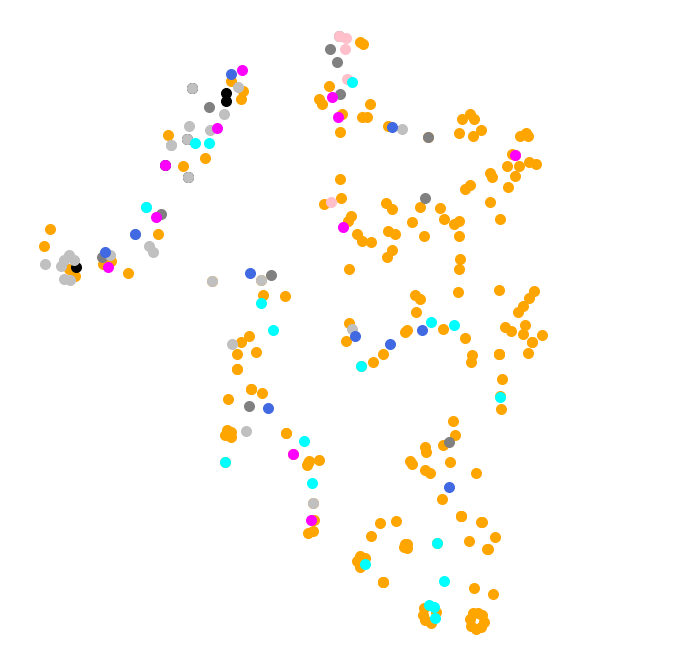

In [27]:
for i in range(len(gray_people_10cat)):
  plot_TSNE(gray_people_10cat[i], features_sar,'responses', targets_material_8, colors_material_8, perplexity_level = 14)
  print("TSNE plot for color observer with 10 categories", i)

# Image Statistic

In [ ]:
image_stat_color = imag_stat(color_attributes_rank)
image_stat_color.to_csv('/content/drive/MyDrive/SAR Color data/image_stats_sept30.csv')